In [ ]:
!pip install transformers
!pip install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 514.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=8b66a5d5699486759adb4f4a26ca7e86539b4b25870503e24ad9708bd2eb610a
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=01e56d23e8f50e9f4db059c011ff266180be897f0c2852a3125b62e485748a63
  Stored in directory: /root/.cache/pip/wheels/9

In [ ]:
!pip install -U LibRecommender

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00


In [ ]:
!pip install transformers torch

In [ ]:
import gzip
import json
import pandas as pd
import re
import numpy as np

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from libreco.data import split_by_ratio

import tqdm
import tensorflow as tf
from pathlib import Path

from libreco.algorithms import DeepFM, YouTubeRanking

from libreco.data import DatasetFeat
from libreco.data import DataInfo

from libreco.evaluation import evaluate

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import torch
print('\nLoading model to GPU...')
device = torch.device('cuda')


Loading model to GPU...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### load the meta data

data = []
with gzip.open('/content/drive/MyDrive/Data_projeto/Digital_Music_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

169781
{'overall': 5.0, 'vote': '3', 'verified': True, 'reviewTime': '06 3, 2013', 'reviewerID': 'A2TYZ821XXK2YZ', 'asin': '3426958910', 'style': {'Format:': ' Audio CD'}, 'reviewerName': 'Garrett', 'reviewText': 'This is awesome to listen to, A must-have for all Slayer fans..sadly needed to be a triple disc set..They have so many hits!!', 'summary': 'Slayer Rules!', 'unixReviewTime': 1370217600}


In [ ]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

169781


In [ ]:
# Display the first few rows of the DataFrame
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


# **1. NLP Data Cleaning and Preprocessing:**

In [ ]:
def show_unique_values(df):
    unique_users = df['user'].unique()
    unique_items = df['item'].unique()
    print("Unique users:", len(unique_users))
    print("Unique items:", len(unique_items))

In [ ]:
def user_item_to_numeric_val(df):
    unique_users = df['user'].unique()
    unique_items = df['item'].unique()

    # users
    user_dict = {}
    all_users = np.arange(1,len(unique_users)+1).tolist()
    for i in range(len(unique_users)):
        user_dict[unique_users[i]] = all_users[i]
    df["user"] = df["user"].map(user_dict)

    # items
    item_dict = {}
    all_items = np.arange(1,len(unique_items)+1).tolist()
    for i in range(len(unique_items)):
        item_dict[unique_items[i]] = all_items[i]
    df["item"] = df["item"].map(item_dict)
    return df

In [ ]:
def decontract(phrase):
    phrase = re.sub(r"[c|C]an\'t", "can not", phrase)
    phrase = re.sub(r"[w|W]on\'t", "will not", phrase)
    phrase = re.sub(r"[a|A]in\'t", "am not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"N\'T", " NOT", phrase)
    return phrase

In [ ]:
def remove_non_english_rows(df):
    non_eng_list = []
    for i in range(len(df)):
        if 'Â' in df['reviews'].iloc[i]:
            print(df['reviews'].iloc[i])
            print(i)
            non_eng_list.append(i)
    return non_eng_list

In [ ]:
def preprocess(df, non_eng_list):
#     df["reviews"] = df["reviews"].apply(lambda x:re.sub(r"[c|C]an\'t", "can not", x))
#     df["reviews"] = df["reviews"].apply(lambda x:re.sub(r"[w|W]on\'t", "will not", x))
#     df["reviews"] = df["reviews"].apply(lambda x:re.sub(r"[a|A]in\'t", "am not",x))

#     df["reviews"] = df["reviews"].apply(lambda x: re.sub(r"n\'t", " not", x))
#     df["reviews"] = df["reviews"].apply(lambda x: re.sub(r"N\'T", " NOT", x))
    df["reviews"] = df["reviews"].apply(lambda x: re.sub('[0-9]','', x))
    for item in non_eng_list:
        df = df.drop(item)
        df = df.reset_index()
        df = df.drop(columns=['index'])
    return df

In [ ]:
df2 = df.filter(['reviewerID', 'asin', 'overall', 'reviewText'])
df2.rename(columns={"reviewerID":"user", "asin":"item", "overall": "label",
                   "reviewText":"reviews"}, inplace=True)
df2.info()

In [ ]:
df2.head()

,user,item,label,reviews
0,1,1,5,"This is awesome to listen to, A must-have for ..."
1,2,1,5,bien
2,3,1,5,It was great to hear the old stuff again and I...
3,4,1,4,well best of's are a bit poison normally but t...
4,5,2,5,What can I say? This is Casting Crowns!!!This ...


In [ ]:
#Convert user Id and item name to numerical value (starting from 1)
show_unique_values(df2)
df2 = user_item_to_numeric_val(df2)
df2['label'] = df2['label'].astype(int)
df2.head(3)
print(df2.shape)

In [ ]:
# remove NA rows
df2 = df2.dropna()
df2 = df2.reset_index()
df2 = df2.drop(columns='index')
print("After removing NA rows", df2.shape)

In [ ]:
# remove reviews with non english characters
non_eng_list = remove_non_english_rows(df2)
df2 = preprocess(df2, non_eng_list)
df2.shape

In [ ]:
print(df2['reviews'][0])

In [ ]:
data_text = df2["reviews"]

In [ ]:
df2.head()


,user,item,label,reviews
0,1,1,5,"This is awesome to listen to, A must-have for ..."
1,2,1,5,bien
2,3,1,5,It was great to hear the old stuff again and I...
3,4,1,4,well best of's are a bit poison normally but t...
4,5,2,5,What can I say? This is Casting Crowns!!!This ...


# **2. Extracting Sentence Embeddings with BERT:**


In [ ]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
use_fixed_padding = True

if use_fixed_padding:
    batch_size = 16
    max_len = 400

    # Tokenize all training examples
    print('Tokenizing {:,} training samples...'.format(len(data_text)))

    batches_input_ids = []
    batches_attention_masks = []
    embeddings = []
    update_interval = batch_size * 150
    for i in range(0, len(data_text), batch_size):
        # Report progress.
        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
            data_text[i:i + batch_size],  # Batch of sentences to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            padding='max_length',  # Pad all to the `max_length` parameter.
            truncation=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )
        # Add the encoded sentence to the list.
        batches_input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        batches_attention_masks.append(encoded_dict['attention_mask'])

Tokenizing 169,623 training samples...
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
  Tokenized 9,600 samples.
  Tokenized 12,000 samples.
  Tokenized 14,400 samples.
  Tokenized 16,800 samples.
  Tokenized 19,200 samples.
  Tokenized 21,600 samples.
  Tokenized 24,000 samples.
  Tokenized 26,400 samples.
  Tokenized 28,800 samples.
  Tokenized 31,200 samples.
  Tokenized 33,600 samples.
  Tokenized 36,000 samples.
  Tokenized 38,400 samples.
  Tokenized 40,800 samples.
  Tokenized 43,200 samples.
  Tokenized 45,600 samples.
  Tokenized 48,000 samples.
  Tokenized 50,400 samples.
  Tokenized 52,800 samples.
  Tokenized 55,200 samples.
  Tokenized 57,600 samples.
  Tokenized 60,000 samples.
  Tokenized 62,400 samples.
  Tokenized 64,800 samples.
  Tokenized 67,200 samples.
  Tokenized 69,600 samples.
  Tokenized 72,000 samples.
  Tokenized 74,400 samples.
  Tokenized 76,800 samples.
  Tokenized 79,200 samples.
  Tokenized 81,600

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')
desc = bert.to(device)

In [ ]:
results = []
# For each batch of training data...
for step in range(0, len(batches_input_ids)):

    # Copy the current training batch to the GPU using the `to` method.
    b_input_ids = batches_input_ids[step].to(device)
    b_input_mask = batches_attention_masks[step].to(device)

    with torch.no_grad():
          outputs = bert(b_input_ids, attention_mask=b_input_mask)
    results.append(outputs[1])

In [ ]:
print(len(results))
print(results[0].shape)
print(results[0][15].shape)

10602
torch.Size([16, 768])
torch.Size([768])


In [ ]:
emb = []
for i in range(len(results)):
  for j in range(len(results[i])):
    emb.append(results[i][j])
print(len(emb))

169623


In [ ]:
embs = [e.cpu().detach().numpy() for e in emb]

In [ ]:
data_len = len(data)
bert_embs = np.array(embs)
print("bert_embs.shape: ", bert_embs.shape)

bert_embs.shape:  (169623, 768)


# **3. Dimensionality Reduction with PCA:**

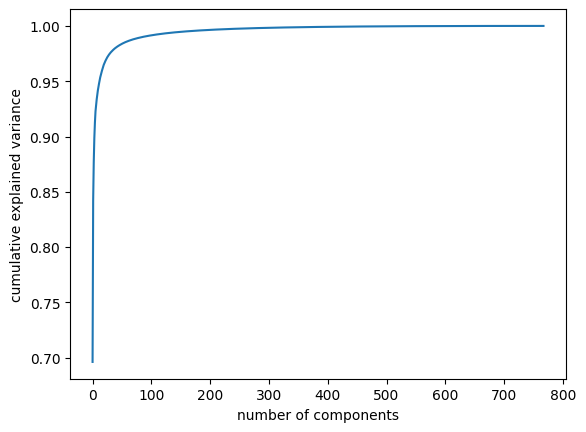

In [ ]:
pca1 = PCA().fit(bert_embs)
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

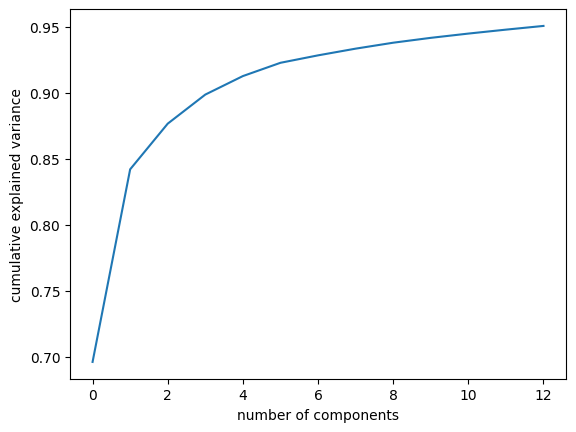

In [ ]:
pca = PCA(0.95)
bbb = pca.fit_transform(bert_embs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

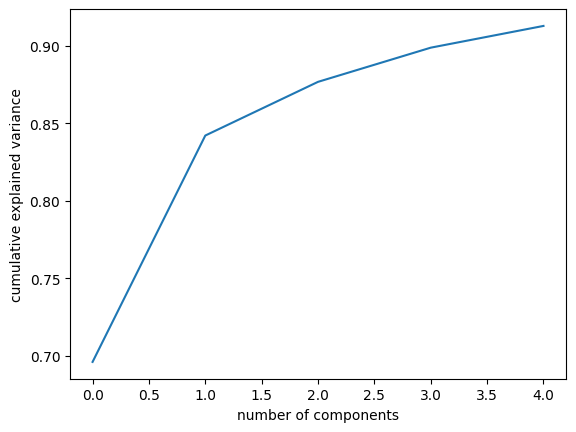

In [ ]:
#pca = PCA(0.90)
#bbb = pca.fit_transform(bert_embs)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance');

In [ ]:
n_comp = pca.n_components_
print(n_comp)
pca = PCA(n_components=n_comp)
bert_emb_pca = pca.fit_transform(bert_embs)
print("bert_emb_pca.shape: ", bert_emb_pca.shape)

In [ ]:
print(pca.explained_variance_)

In [ ]:
for i in range(n_comp):
    col_val = 'review_emb{}'.format(i+1)
    df2[col_val] = bert_emb_pca[:,i]

In [ ]:
df2.head()

,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13
0,1,1,5,"This is awesome to listen to, A must-have for ...",-3.976662,-0.222314,0.740003,-0.281733,-0.900463,-0.654161,0.279225,-0.019154,-0.704252,0.004212,-0.202755,-0.033547,-0.336393
1,2,1,5,bien,9.395696,-1.559125,1.081266,0.652833,-0.034893,0.522941,-0.733109,-0.317292,-0.215632,-0.279097,-0.531449,-0.463919,0.426434
2,3,1,5,It was great to hear the old stuff again and I...,-2.968925,-0.186041,-1.128273,-0.030470,0.436514,-0.581221,-0.620465,-0.442224,0.301142,0.197299,0.331702,0.002399,0.334371
3,4,1,4,well best of's are a bit poison normally but t...,-3.495623,5.017088,0.032723,0.372174,-0.474481,-0.132257,0.504892,0.540738,0.532467,-0.931830,-0.312467,0.174398,-0.315474
4,5,2,5,What can I say? This is Casting Crowns!!!This ...,-0.580985,0.935905,-1.162975,-0.830482,-1.155285,-0.303389,-0.107746,-0.296417,-0.180111,-0.087021,0.172724,0.119264,-0.055282


# **4.Splitting the Dataset:**

In [ ]:
# Split the DataFrame into training (80%) and testing (20%) subsets
#train_df, test_df = train_test_split(df2, test_size=0.2, random_state=42)
train_df, test_df = split_by_ratio(df2, test_size=0.2)
# Display the number of samples in each subset
print("Number of samples in training subset:", len(train_df))
print("Number of samples in testing subset:", len(test_df))

Number of samples in training subset: 136480
Number of samples in testing subset: 31391


In [ ]:
train_df.head()

,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13
0,1,1,5,"This is awesome to listen to, A must-have for ...",-3.976662,-0.222314,0.740003,-0.281733,-0.900463,-0.654161,0.279225,-0.019154,-0.704252,0.004212,-0.202755,-0.033547,-0.336393
102863,1,8240,4,Still better than ever. One of my all time fav...,-2.567030,-2.993482,-0.140020,0.915301,0.399198,0.116555,-0.190191,0.221334,0.577222,0.292899,0.158196,0.407354,-0.333497
112310,1,8965,5,This band had to grow on me and I'm glad I hav...,-2.925392,0.422628,-0.358168,-0.490104,-0.539603,-0.282363,-0.009856,-0.466356,-0.080694,0.298995,0.209055,0.403626,-0.124510
112356,1,8967,5,"Even though I enjoyed ""Atlas"" I think ""Ire"" ve...",-4.972925,-1.129824,0.215336,0.337715,0.267646,-1.471573,0.060090,-0.226761,0.110492,0.182117,0.627500,-0.489313,-0.179741
113595,1,9074,5,No Surprise. Sevendust made yet again another ...,-5.239686,1.968060,0.914286,0.316176,0.003507,-0.922557,-0.613515,-0.396587,-0.522224,-0.473485,0.356244,0.028707,-0.634657


In [ ]:
df2.shape

(169623, 17)

In [ ]:
train_df.shape

(136480, 17)

In [ ]:
test_df.shape

(31391, 17)

# **5. Extract Sentiment**


In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import tokenize
import pandas as pd


In [ ]:
def get_negations(review):
    analyzer = SentimentIntensityAnalyzer()
    sentence_list = tokenize.sent_tokenize(review)
    review_negations = 0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        review_negations += vs["negations_captured"]
    return review_negations

def get_sentiment(review):
    analyzer = SentimentIntensityAnalyzer()
    sentence_list = tokenize.sent_tokenize(review)
    review_sentiment = 0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        review_sentiment += round(vs["compound"] / len(sentence_list), 4)
    return review_sentiment


In [ ]:
train_df['vader_sentiment_score'] = train_df['reviews'].apply(get_sentiment)
test_df['vader_sentiment_score'] = test_df['reviews'].apply(get_sentiment)

<ipython-input-49-bcf88e58fe65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['vader_sentiment_score'] = train_df['reviews'].apply(get_sentiment)


In [ ]:
test_df.head()


,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13,vader_sentiment_score
118815,1,9550,5,Volbeat always outdo themselves!!,-0.040584,-2.302408,0.152096,0.127359,-1.599225,0.036020,0.400863,0.510843,0.030752,-0.169429,0.342325,0.031819,-0.518727,0.0000
119043,1,9568,5,This album is great. If I had to pick a favori...,-5.339437,-2.117825,0.857811,-0.504301,0.484158,-0.859475,-0.025221,-0.151733,0.318666,0.272427,0.358081,-0.367976,-0.113247,0.3909
117186,2,9398,5,EXCELENTE,11.254141,0.030462,1.860533,0.244722,-0.018016,-0.067173,-0.468654,-0.206963,-0.123733,-0.221078,-0.299097,-0.406332,0.356064,0.0000
143983,2,4090,5,fine,11.796465,0.145401,1.305953,0.397526,0.382264,-0.490472,-0.563322,-0.085825,0.067490,0.051787,-0.382608,0.033500,0.006070,0.2023
165767,3,8524,5,Great Album. A must have.,-3.786006,-3.766039,1.176013,0.747948,-0.197181,0.082252,0.060217,-0.245357,0.288221,0.502501,0.117319,0.212182,-0.278723,0.3125


In [ ]:
train_df.head()

,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13,vader_sentiment_score
0,1,1,5,"This is awesome to listen to, A must-have for ...",-3.976662,-0.222314,0.740003,-0.281733,-0.900463,-0.654161,0.279225,-0.019154,-0.704252,0.004212,-0.202755,-0.033547,-0.336393,0.3294
102863,1,8240,4,Still better than ever. One of my all time fav...,-2.567030,-2.993482,-0.140020,0.915301,0.399198,0.116555,-0.190191,0.221334,0.577222,0.292899,0.158196,0.407354,-0.333497,0.4496
112310,1,8965,5,This band had to grow on me and I'm glad I hav...,-2.925392,0.422628,-0.358168,-0.490104,-0.539603,-0.282363,-0.009856,-0.466356,-0.080694,0.298995,0.209055,0.403626,-0.124510,0.2031
112356,1,8967,5,"Even though I enjoyed ""Atlas"" I think ""Ire"" ve...",-4.972925,-1.129824,0.215336,0.337715,0.267646,-1.471573,0.060090,-0.226761,0.110492,0.182117,0.627500,-0.489313,-0.179741,0.2773
113595,1,9074,5,No Surprise. Sevendust made yet again another ...,-5.239686,1.968060,0.914286,0.316176,0.003507,-0.922557,-0.613515,-0.396587,-0.522224,-0.473485,0.356244,0.028707,-0.634657,0.1515


In [ ]:
dataframe_eda = pd.concat([train_df, test_df], ignore_index=True)


# **6 Análise de Dados**

In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

In [ ]:
# Changes the overall category to categorical from numerical for easier visualizations
df2["classes"] = df2["label"]
df2["classes"].replace({5.0: "positivo",4.0:"positivo",3.0:"neutro",2.0:"negativo",1.0:"negativo"}, inplace=True)
df2["classes"].unique()

array(['positivo', 'negativo', 'neutro'], dtype=object)

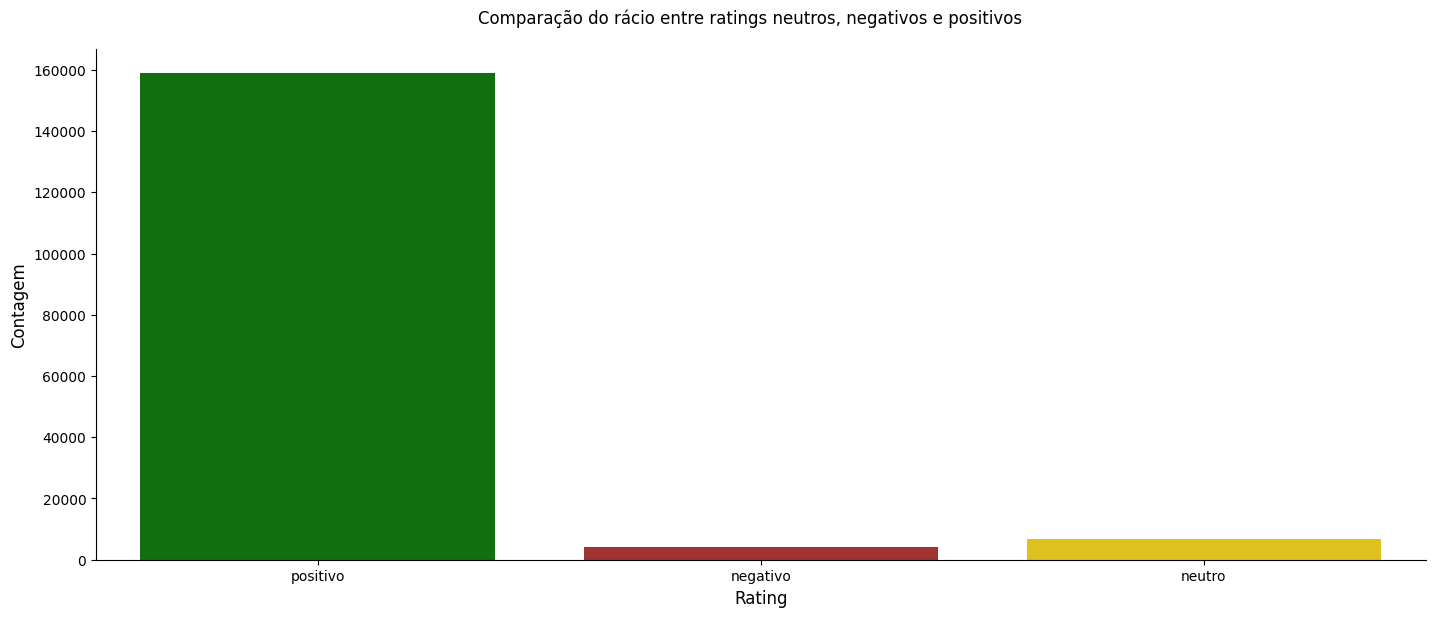

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of sentiment class
cores = ["#008000","#B22222", "#FFD700"]
fig, axes = plt.subplots(1, figsize=(14,6))
fig.suptitle("Comparação do rácio entre ratings neutros, negativos e positivos", fontsize = 12)
plt.tight_layout(pad = 1)
sns.countplot(x="classes", data=df2, palette=cores)  # Use a paleta de cores
axes.set_xlabel("Rating", fontsize=12)
axes.set_ylabel("Contagem", fontsize=12)
# Mantenha os eixos visíveis
axes.spines['top'].set_visible(True)
axes.spines['right'].set_visible(True)
axes.spines['bottom'].set_visible(True)
axes.spines['left'].set_visible(True)
sns.despine()
sns.despine()

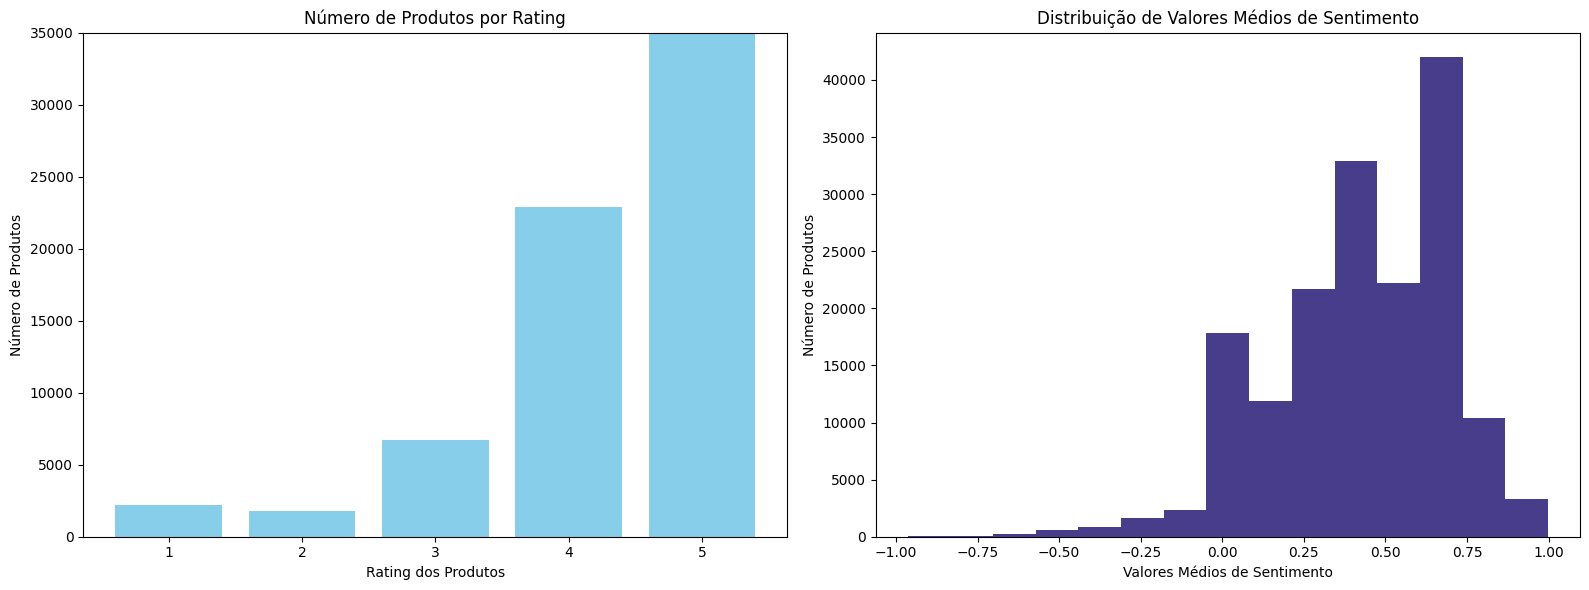

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already defined the 'dataframe_eda'

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Subplot 1 - Number of Products by Rating
plt.subplot(1, 2, 1)
rating_counts = dataframe_eda['label'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating dos Produtos')
plt.ylabel('Número de Produtos')
plt.title('Número de Produtos por Rating')
plt.xticks(rating_counts.index)
plt.ylim(0, 35000)

# Subplot 2 - Distribution of Vader Sentiment Scores
plt.subplot(1, 2, 2)
dataframe_eda["vader_sentiment_score"].hist(bins=15, color='darkslateblue')
plt.xlabel("Valores Médios de Sentimento")
plt.ylabel("Número de Produtos")
plt.grid(False)
plt.title("Distribuição de Valores Médios de Sentimento")

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig("DatafintiHotel_rating_senti.png", facecolor='w')

# Show the figure (optional)
plt.show()


<ipython-input-222-271a28f07a61>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


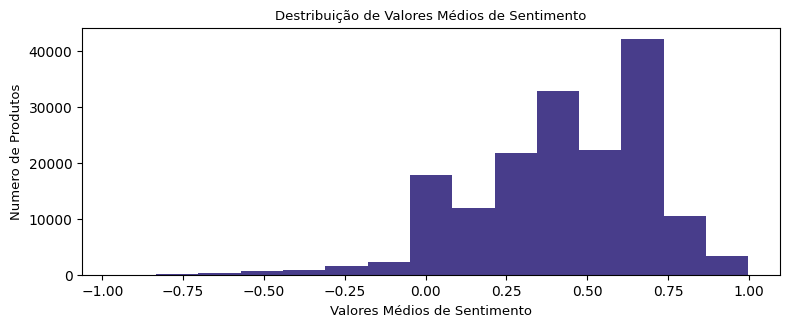

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
classlabels = ['1','2','3','4','5']
classCount = [len(dataframe_eda[dataframe_eda.label == 1]),
              len(dataframe_eda[dataframe_eda.label == 2]),
              len(dataframe_eda[dataframe_eda.label == 3]),
              len(dataframe_eda[dataframe_eda.label == 4]),
              len(dataframe_eda[dataframe_eda.label == 5])]

plt.bar(classlabels,classCount, width= 0.5, align='center',
       color=['#ffadac', '#ffadac', '#ffd6a6', '#caf6ad','#caf6ad'],
       edgecolor = 'white')
plt.xlabel('Ratings', fontsize=9.5)
plt.ylabel("Número de reviews", fontsize=9.5)
# Creating the legend of the bars in the plot
plt.title('Número de produtos avaliados de 1 a 5 pelos utilizadores', fontsize=9.5)

colors = {'Produtos com reviews negativas':'#ffadac', 'Produtos com reviews neutras':'#ffd6a6',
          'Produtos com reviews positivas':'#caf6ad'}

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.subplot(2, 1, 2)
dataframe_eda["vader_sentiment_score"].hist(bins=15, color= "darkslateblue")
plt.xlabel("Valores Médios de Sentimento", fontsize=9.5)
plt.ylabel("Numero de Produtos", fontsize=9.5)
plt.grid(False)
plt.title("Destribuição de Valores Médios de Sentimento", fontsize=9.5)
plt.tight_layout()
plt.savefig("DatafintiHotel_rating_senti.png", facecolor='w')

In [ ]:
dataframe_eda.head()

,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,vader_sentiment_score
0,1,1,5,"This is awesome to listen to, A must-have for ...",-3.976655,-0.222418,0.740186,-0.281672,-0.900523,0.3294
1,1,8240,4,Still better than ever. One of my all time fav...,-2.567030,-2.993481,-0.140022,0.915299,0.399200,0.4496
2,1,8965,5,This band had to grow on me and I'm glad I hav...,-2.925393,0.422628,-0.358170,-0.490102,-0.539603,0.2031
3,1,8967,5,"Even though I enjoyed ""Atlas"" I think ""Ire"" ve...",-4.972925,-1.129824,0.215336,0.337716,0.267645,0.2773
4,1,9074,5,No Surprise. Sevendust made yet again another ...,-5.239688,1.968060,0.914288,0.316176,0.003507,0.1515


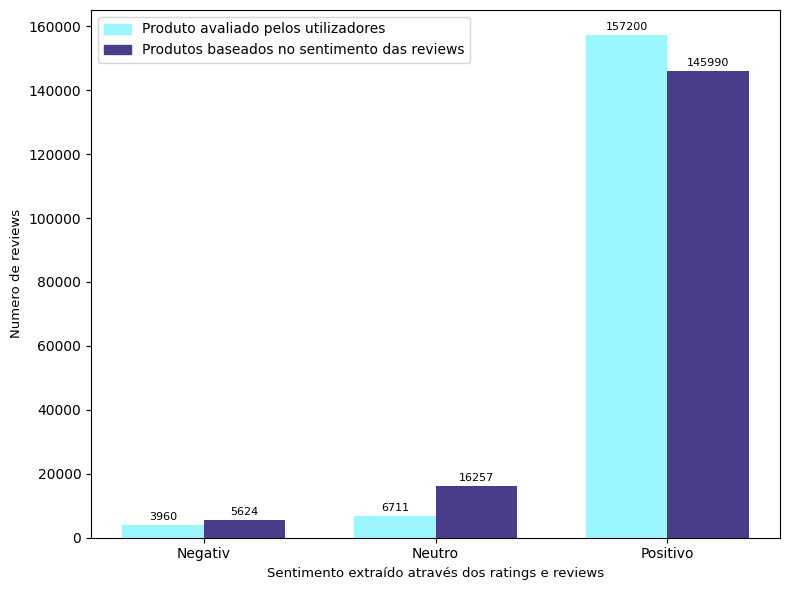

In [ ]:
# https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html
labels = ["Negativo", "Neutro", "Positivo"]
neg = dataframe_eda[(dataframe_eda['label']>=1) & (dataframe_eda['label']<=2)]
neu = dataframe_eda[dataframe_eda['label']==3]
pos = dataframe_eda[(dataframe_eda['label']>=4) & (dataframe_eda['label']<=5)]

reviews = [len(neg), len(neu), len(pos)]


neg_senti = dataframe_eda[dataframe_eda['vader_sentiment_score']<= -0.05]
neu_senti = dataframe_eda[(dataframe_eda['vader_sentiment_score']> -0.05) & (dataframe_eda['vader_sentiment_score']< 0.05)]
pos_senti = dataframe_eda[dataframe_eda['vader_sentiment_score']>= 0.05]
reviews_senti = [len(neg_senti), len(neu_senti), len(pos_senti)]


x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width / 2, reviews, width,
                color='#9bf6ff')
rects2 = ax.bar(x + width / 2, reviews_senti, width,
                color="darkslateblue")


ax.set_ylabel('Numero de reviews', fontsize=9.5)
ax.set_xlabel("Sentimento extraído através dos ratings e reviews", fontsize=9.5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend(loc=9)

def vanlabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)


autolabel(rects1)
autolabel(rects2)


colors = {'Produto avaliado pelos utilizadores':'#9bf6ff', "Produtos baseados no sentimento das reviews":"darkslateblue"}

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)


fig.tight_layout()
#plt.legend(loc=2)
plt.savefig('Reviews_Negs_Games.png', facecolor='w')

In [ ]:
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=6)

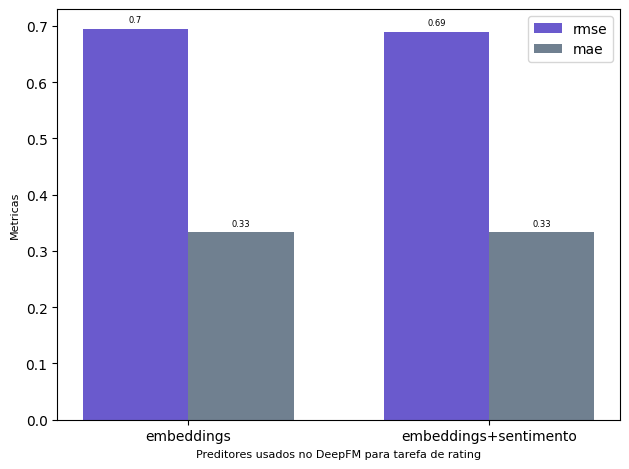

In [ ]:
#METRICAS DEEPFM RATING
# region Plot
# https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html
labels = ["embeddings", "embeddings+sentimento"]
rmse = [0.69541866, 0.69013894]

mae = [0.3328928, 0.33408594]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, rmse, width, label='rmse', color="#6A5ACD")
rects2 = ax.bar(x + width / 2, mae, width, label='mae', color="#708090")

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Metricas', fontsize=8)
ax.set_xlabel('Preditores usados no DeepFM para tarefa de rating', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# ax.legend(loc=9)
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


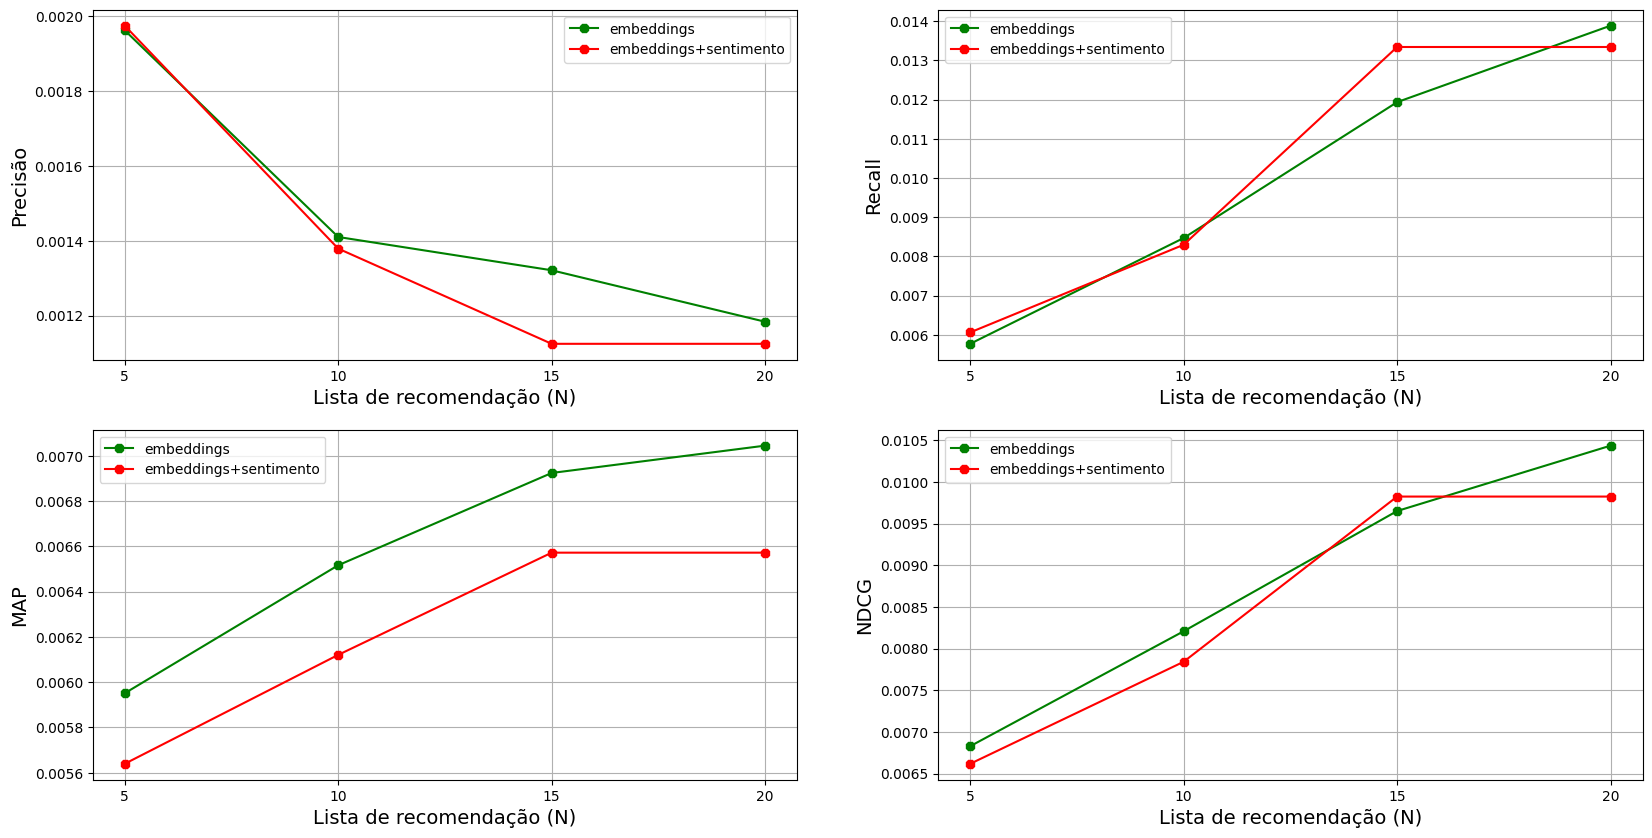

In [ ]:
#--------------------------------------DeepFM RANKING

#---------------------------------------------------MAP---------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5': 0.005951049832627409,'10': 0.006516830471065092, '15':0.0069246934924692615, '20': 0.007045527146281048}
result_with_embeddings_senti={'5':0.005639416946322448,'10': 0.006120793920823514, '15':0.006572535916874091,'20': 0.006572535916874091}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[1, 0].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[1, 0].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 0].set_ylabel('MAP', fontsize=14)
axes[1, 0].grid()
axes[1, 0].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion


#--------------------------------------------------PRECISÃO----------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5': 0.001962976767300286,'10': 0.0014101130575226736, '15':0.0013210750817906987, '20':  0.0011833768169959}
result_with_embeddings_senti={'5':0.0019754006708907943,'10': 0.0013790532985464032, '15':0.0011243632749409866,'20': 0.0011243632749409866}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[0, 0].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 0].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[0, 0].set_ylabel('Precisão', fontsize=14)
axes[0, 0].grid()
axes[0, 0].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

#--------------------------------------------------RECALL----------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5':0.005770830873631924 ,'10': 0.008469568735899418 , '15':0.011937119668974018, '20': 0.013888818785693634}
result_with_embeddings_senti={'5':0.006061509169038055,'10': 0.00829804984466379, '15': .013343646063853003,'20':0.013343646063853003}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[0, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[0, 1].set_ylabel('Recall', fontsize=14)
axes[0, 1].grid()
axes[0, 1].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

#---------------------------------------------------NDCG---------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5':0.00682910314148265 ,'10': 0.008208924229647821 , '15':0.00965208492849859, '20':0.010436916005897419 }
result_with_embeddings_senti={'5':0.006617981837034346,'10': 0.00784270067502607 , '15':0.009825573918258477,'20':0.009825573918258477}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[1, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[1, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 1].set_ylabel('NDCG', fontsize=14)
axes[1, 1].grid()
axes[1, 1].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

In [ ]:
#SEM SENTIMENTO
#evaluate_result (k=5):  {'recall': 0.00056642734121851, 'ndcg': 0.00057744092135377}
#evaluate_result (k=10):  {'recall': 0.0009523213163782324, ''ndcg': 0.0008193452473558206}
#evaluate_result (k=15):  {'recall': 0.0014764917250063379, 'ndcg': 0.0010670013594186554
#evaluate_result (k=20):  { 'recall': 0.013888818785693634, 'ndcg': 0.010436916005897419}

#COM SENTIMENTO
#evaluate_result (k=5):  { 'recall': 0.005495334133984897, 'ndcg': 0.005994310504192234}
#evaluate_result (k=10):  {'recall': 0.006764938758043491, 'ndcg': 0.006651662659782092}
#evaluate_result (k=15):  { 'recall': 0.011016009087198055, 'ndcg': 0.008398703412003852}
#evaluate_result (k=20):  { 'recall': 0.012423533831472705, 'ndcg': 0.008982242131507941}

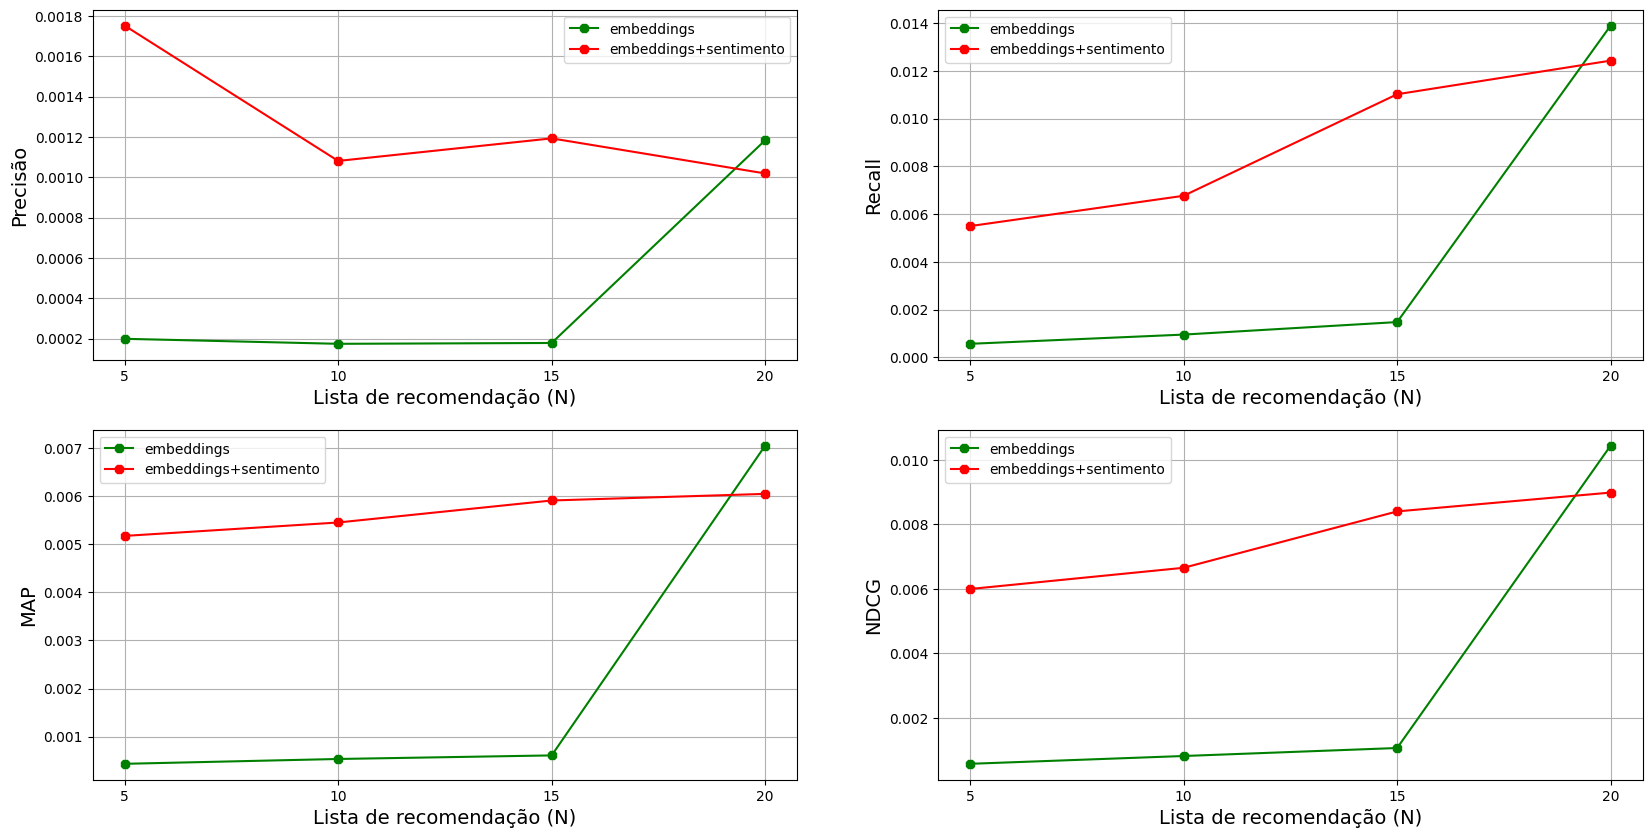

In [ ]:
#--------------------------------------YOUTUBERANKER RANKING

#---------------------------------------------------MAP---------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5':  0.0004369072789197413,'10': 0.0005372105822835388, '15':0.0006114550963264472, '20': 0.007045527146281048}
result_with_embeddings_senti={'5':0.00517041458411459,'10': 0.005449089649423692, '15':0.005906150105529312,'20': 0.006043345399792409}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[1, 0].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[1, 0].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 0].set_ylabel('MAP', fontsize=14)
axes[1, 0].grid()
axes[1, 0].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion


#--------------------------------------------------PRECISÃO----------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5': 0.0001987824574481302,'10': 0.00017393465026711394, '15':0.00017807595146394998, '20': 0.0011833768169959}
result_with_embeddings_senti={'5':0.0017517704062616475,'10':0.001080879612374208,'15':0.0011926947446887813,'20':0.0010187600944216672 }
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[0, 0].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 0].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[0, 0].set_ylabel('Precisão', fontsize=14)
axes[0, 0].grid()
axes[0, 0].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

#--------------------------------------------------RECALL----------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5':0.00056642734121851,'10':0.0009523213163782324, '15':0.0014764917250063379, '20':0.013888818785693634}
result_with_embeddings_senti={'5': 0.005495334133984897,'10': 0.006764938758043491, '15':0.011016009087198055,'20':0.012423533831472705}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[0, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[0, 1].set_ylabel('Recall', fontsize=14)
axes[0, 1].grid()
axes[0, 1].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

#---------------------------------------------------NDCG---------------------------------------------
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion

result_with_embeddings={'5':0.00057744092135377,'10': 0.0008193452473558206, '15':0.0010670013594186554, '20':0.010436916005897419}
result_with_embeddings_senti={'5':0.005994310504192234,'10':0.006651662659782092, '15':0.008398703412003852,'20':0.008982242131507941}
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v)
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v)

axes[1, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[1, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='embeddings+sentimento', marker='8')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 1].set_ylabel('NDCG', fontsize=14)
axes[1, 1].grid()
axes[1, 1].set_xticks(x_embeddings)
#plt.yticks(rotation=60)
#plt.legend(loc=0)
# endregion

In [ ]:

# region Plot recall metrics only
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
# endregion
result_with_embeddings={'5':0.00577083087363192,'10': 0.008469568735899418, '15': 0.011937119668974018,'20':0.013888818785693634}
result_with_embeddings_senti=
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v["recall"])
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v["recall"])

axes[0, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='e', marker='8')
axes[0, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 0].set_ylabel('Recall', fontsize=14)
axes[1, 0].grid()
axes[1, 0].set_xticks(x_p1)
#plt.yticks(rotation=60)
axes[1, 0].legend(loc=0)
# endregion

# region Plot ndcg metrics only
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
result_with_embeddings=
result_with_embeddings_senti=
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v["ndcg"])
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v["ndcg"])

axes[0, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='e', marker='8')
axes[0, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 1].set_ylabel('NDCG', fontsize=14)
axes[1, 1].grid()
axes[1, 1].set_xticks(x_p1)
# plt.yticks(rotation=60)
# plt.legend(loc=0)
# endregion

# region Plot AUC-Roc metrics only
# region common variable declare
x = ["embeddings", "embeddings+sentimento"]
y_label = [5, 10, 15, 20, 25]
x_embeddings = []
x_emb_sentimento = []

y_embeddings = []
y_emb_sentimento = []
result_with_embeddings=
result_with_embeddings_senti=
for f, v in result_with_embeddings.items():
    x_embeddings.append(f)
    y_embeddings.append(v["ndcg"])
for f, v in result_with_embeddings_senti.items():
    x_emb_sentimento.append(f)
    y_emb_sentimento.append(v["ndcg"])

axes[0, 1].plot(x_embeddings, y_embeddings, 'g', label='embeddings', marker='8')
axes[0, 1].plot(x_emb_sentimento, y_emb_sentimento, 'r', label='e', marker='8')
axes[0, 1].set_xlabel('Lista de recomendação (N)', fontsize=14)
axes[1, 1].set_ylabel('NDCG', fontsize=14)
axes[1, 1].grid()
axes[1, 1].set_xticks(x_p1)
# plt.yticks(rotation=60)
# plt.legend(loc=0)
# endregion

plt.savefig('Whole_Music_metrics@N.png', dpi=600)

In [ ]:
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Percentage of neutral words --> {pert_count(dfEDA, 'neutral')} %")
print(f"Percentage of negative words --> {pert_count(dfEDA, 'negative')} %")
print(f"Percentage of positive words --> {pert_count(dfEDA, 'positive')} %")

Percentage of neutral words --> 4.004173962257477 %
Percentage of negative words --> 2.3605289377030236 %
Percentage of positive words --> 93.6352971000395 %


In [ ]:
neu=df2[df2["classes"] == "neutro"]["reviews"]
neg=df2[df2["classes"] == "negativo"]["reviews"]
pos=df2[df2["classes"] == "positivo"]["reviews"]

In [ ]:
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5,7.5))
    plt.axis("off")
    if title:
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()

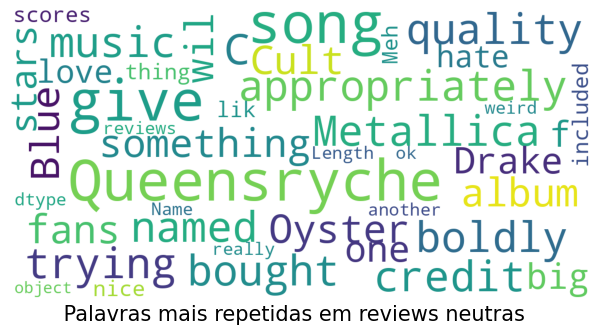

In [ ]:

word_cloud(neu, " Palavras mais repetidas em reviews neutras")


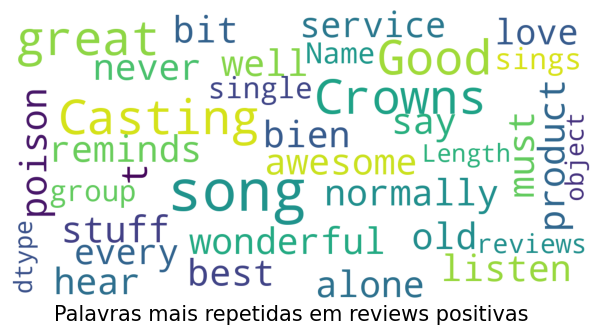

In [ ]:
word_cloud(pos, "Palavras mais repetidas em reviews positivas")


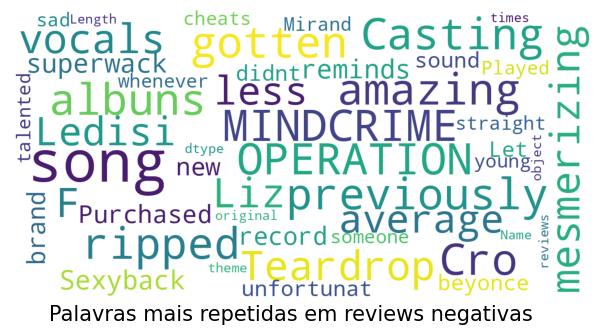

In [ ]:
word_cloud(neg, "Palavras mais repetidas em reviews negativas")

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]# apply function above

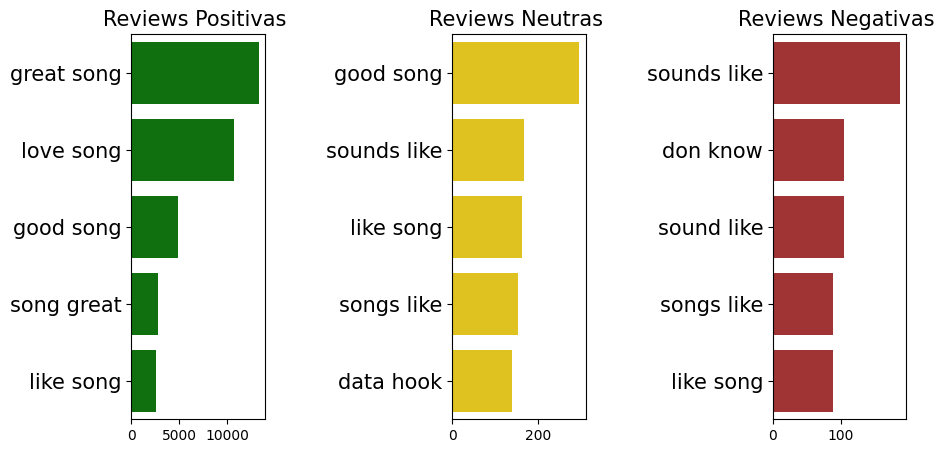

In [ ]:
# create a function for bigram plots
def n_gram_plot(data, title, color):
    x = [x[0] for x in data]
    y = [x[1] for x in data]
    sns.barplot(y=x, x=y, color='{}'.format(color))
    plt.title('Reviews {} '.format(title), fontsize=15)
    plt.yticks(rotation=0, fontsize=15)

common_words_good = get_top_n_bigram(pos, 5)
common_words_neutral= get_top_n_bigram(neu, 5)
common_words_bad= get_top_n_bigram(neg, 5)

plt.figure(figsize=(10, 5))

# Good reviews bigrams
plt.subplot(151)
n_gram_plot(common_words_good, 'Positivas', "#008000")

# Neutral reviews bigrams
plt.subplot(153)
n_gram_plot(common_words_neutral, 'Neutras', "#FFD700")

# Bad reviews bigrams
plt.subplot(155)
n_gram_plot(common_words_bad, 'Negativas', "#B22222")

plt.show()

In [ ]:
# calculating sentiment polarity using external libraries
dfEDA['sentiment'] = dfEDA['reviews'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
dfEDA.head()

,user,item,label,reviews,classes,sentiment
0,1,1,5,"This is awesome to listen to, A must-have for ...",positive,0.890625
1,2,1,5,bien,positive,0.000000
2,3,1,5,It was great to hear the old stuff again and I...,positive,0.345455
3,4,1,4,well best of's are a bit poison normally but t...,positive,0.328053
4,5,2,5,What can I say? This is Casting Crowns!!!This ...,positive,0.550000


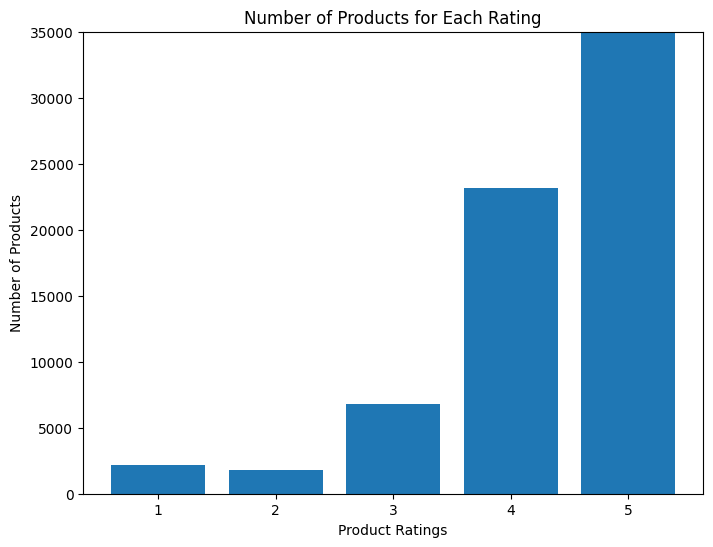

In [ ]:
rating_counts = dfEDA['label'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Product Ratings')
plt.ylabel('Number of Products')
plt.title('Number of Products for Each Rating')
plt.xticks(rating_counts.index)
plt.ylim(0, 35000)
plt.show()

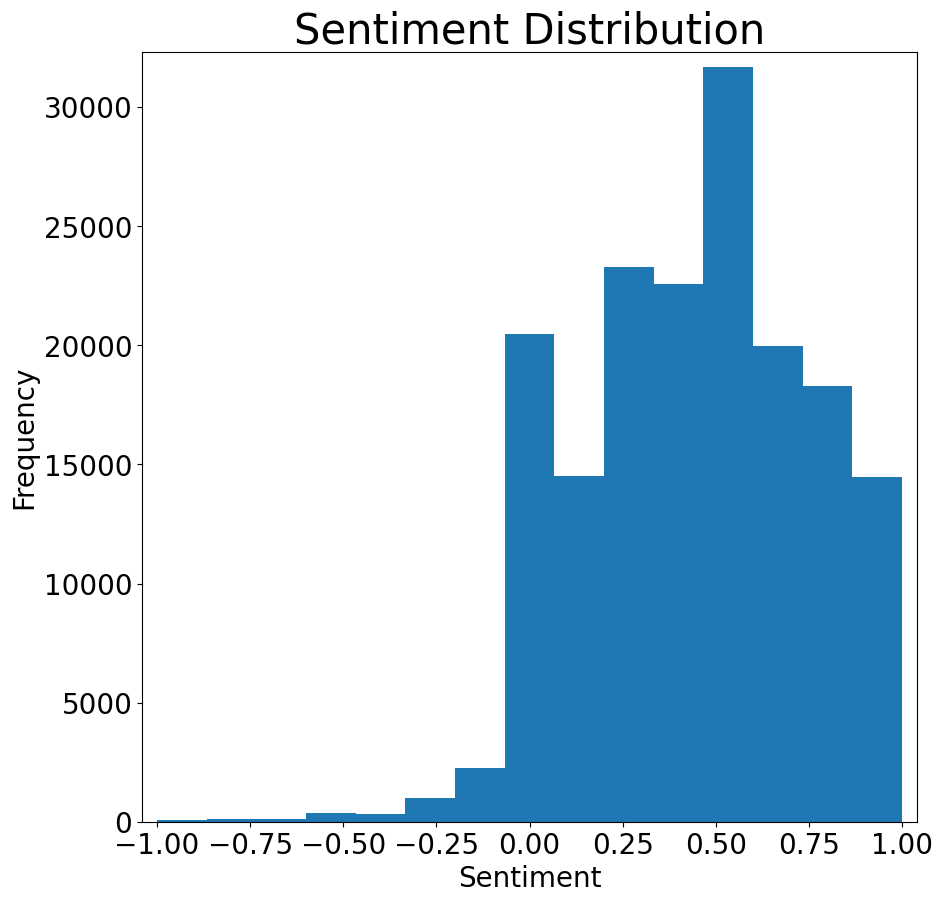

In [ ]:
plt.figure(figsize=(10,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.hist(dfEDA['sentiment'], bins=15)
plt.title('Sentiment Distribution', fontsize=30)
plt.show()

<Axes: >

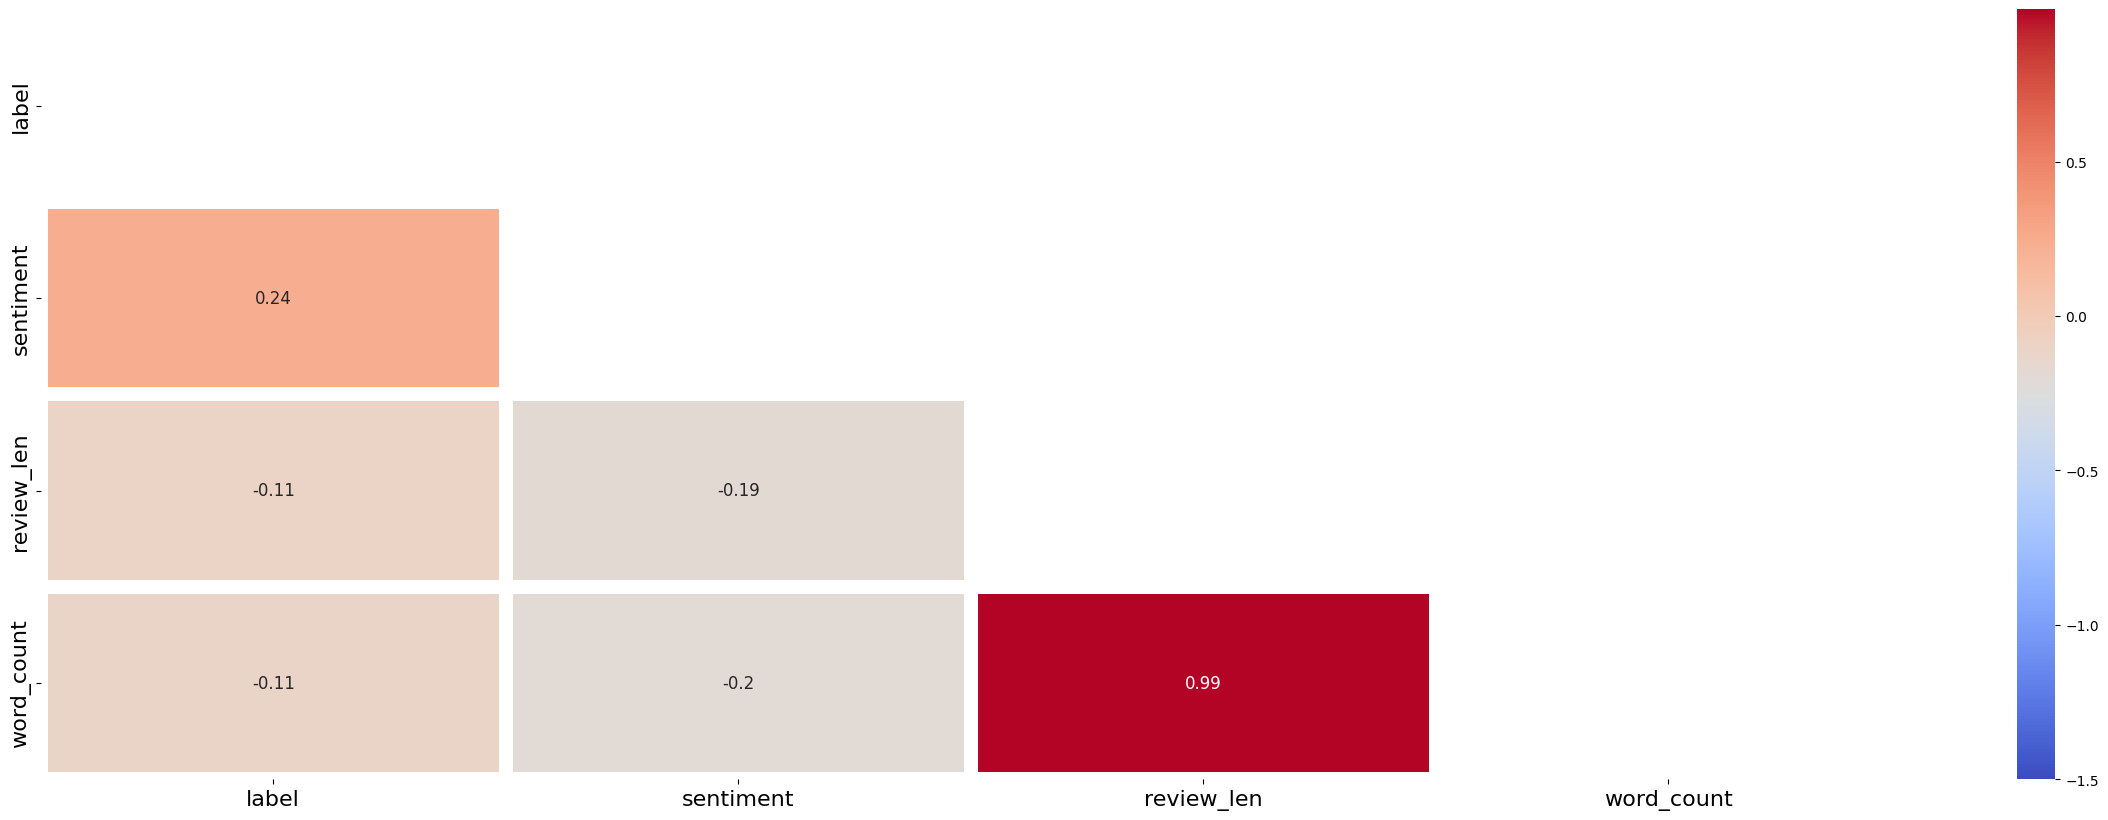

In [ ]:
# Heatmap from overall rating, review length, sentiment and word count

# calculating word count and review length
dfEDA['word_count'] = dfEDA["reviews"].apply(lambda x: len(str(x).split(" ")))
dfEDA['review_len'] =dfEDA["reviews"].apply(lambda x: len(str(x)))

# visualising the heatmap
correlation = dfEDA[['label','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 12}, linewidths=10, vmin=-1.5, mask=mask)

# **7. Embeddings + Ratings**

# **7.1 DeepFM - Rating**

In [ ]:
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
item_col = []

In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col)

In [ ]:
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
reset_state("DeepFM")
deepfm = DeepFM("rating", data_info, embed_size=16, n_epochs=15,
                    lr=1e-3, lr_decay=False, reg=None, batch_size=64,
                    num_neg=1, use_bn=False, dropout_rate=None,
                    hidden_units=(128,64,32), tf_sess_config=None)


 ============================== DeepFM ==============================


In [ ]:
deepfm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,neg_sampling=False,
               metrics=["rmse", "loss", "r2", "mae"])

Training start time: 2023-09-06 12:18:30
total params: 517,709 | embedding params: 476,685 | network params: 41,024


train: 100%|██████████| 4265/4265 [00:21<00:00, 195.87it/s]


Epoch 1 elapsed: 21.779s
	 train_loss: 0.4595


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 64.38it/s]


	 eval rmse: 0.6313
	 eval rmse: 0.6313
	 eval r2: 0.2386
	 eval mae: 0.3426


train: 100%|██████████| 4265/4265 [00:22<00:00, 189.01it/s]


Epoch 2 elapsed: 22.574s
	 train_loss: 0.2321


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 231.82it/s]


	 eval rmse: 0.6448
	 eval rmse: 0.6448
	 eval r2: 0.2059
	 eval mae: 0.3859


train: 100%|██████████| 4265/4265 [00:22<00:00, 193.78it/s]


Epoch 3 elapsed: 22.021s
	 train_loss: 0.1723


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 357.31it/s]


	 eval rmse: 0.6439
	 eval rmse: 0.6439
	 eval r2: 0.2080
	 eval mae: 0.3165


train: 100%|██████████| 4265/4265 [00:21<00:00, 200.44it/s]


Epoch 4 elapsed: 21.289s
	 train_loss: 0.1293


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 237.57it/s]


	 eval rmse: 0.6662
	 eval rmse: 0.6662
	 eval r2: 0.1522
	 eval mae: 0.3339


train: 100%|██████████| 4265/4265 [00:23<00:00, 184.69it/s]


Epoch 5 elapsed: 23.103s
	 train_loss: 0.0992


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 278.86it/s]


	 eval rmse: 0.6605
	 eval rmse: 0.6605
	 eval r2: 0.1667
	 eval mae: 0.3529


train: 100%|██████████| 4265/4265 [00:21<00:00, 199.11it/s]


Epoch 6 elapsed: 21.433s
	 train_loss: 0.0768


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 289.04it/s]


	 eval rmse: 0.6781
	 eval rmse: 0.6781
	 eval r2: 0.1216
	 eval mae: 0.3501


train: 100%|██████████| 4265/4265 [00:23<00:00, 185.13it/s]


Epoch 7 elapsed: 23.047s
	 train_loss: 0.0619


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 346.90it/s]


	 eval rmse: 0.6891
	 eval rmse: 0.6891
	 eval r2: 0.0931
	 eval mae: 0.3657


train: 100%|██████████| 4265/4265 [00:21<00:00, 200.64it/s]


Epoch 8 elapsed: 21.263s
	 train_loss: 0.0503


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 352.15it/s]


	 eval rmse: 0.6810
	 eval rmse: 0.6810
	 eval r2: 0.1142
	 eval mae: 0.3289


train: 100%|██████████| 4265/4265 [00:22<00:00, 188.16it/s]


Epoch 9 elapsed: 22.675s
	 train_loss: 0.0418


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 236.81it/s]


	 eval rmse: 0.6767
	 eval rmse: 0.6767
	 eval r2: 0.1253
	 eval mae: 0.3394


train: 100%|██████████| 4265/4265 [00:21<00:00, 198.90it/s]


Epoch 10 elapsed: 21.451s
	 train_loss: 0.0357


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 271.90it/s]


	 eval rmse: 0.6792
	 eval rmse: 0.6792
	 eval r2: 0.1189
	 eval mae: 0.3532


train: 100%|██████████| 4265/4265 [00:22<00:00, 189.79it/s]


Epoch 11 elapsed: 22.481s
	 train_loss: 0.0304


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 197.18it/s]


	 eval rmse: 0.6925
	 eval rmse: 0.6925
	 eval r2: 0.0839
	 eval mae: 0.3398


train: 100%|██████████| 4265/4265 [00:22<00:00, 189.53it/s]


Epoch 12 elapsed: 22.512s
	 train_loss: 0.0268


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 370.14it/s]


	 eval rmse: 0.6818
	 eval rmse: 0.6818
	 eval r2: 0.1120
	 eval mae: 0.3454


train: 100%|██████████| 4265/4265 [00:21<00:00, 199.44it/s]


Epoch 13 elapsed: 21.397s
	 train_loss: 0.0234


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 336.47it/s]


	 eval rmse: 0.6866
	 eval rmse: 0.6866
	 eval r2: 0.0996
	 eval mae: 0.3424


train: 100%|██████████| 4265/4265 [00:23<00:00, 182.96it/s]


Epoch 14 elapsed: 23.319s
	 train_loss: 0.021


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 337.94it/s]


	 eval rmse: 0.6836
	 eval rmse: 0.6836
	 eval r2: 0.1074
	 eval mae: 0.3438


train: 100%|██████████| 4265/4265 [00:21<00:00, 201.66it/s]


Epoch 15 elapsed: 21.160s
	 train_loss: 0.0188


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 251.26it/s]


	 eval rmse: 0.6845
	 eval rmse: 0.6845
	 eval r2: 0.1049
	 eval mae: 0.3311


In [ ]:
deepfm.save('/content/drive/MyDrive/projeto', model_name="DeepFM_atual_raiting_sem_sentimento")

In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data,neg_sampling=False,
                                      metrics=["rmse", "loss", "r2", "mae"])

eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 182.88it/s]


In [ ]:
print("evaluate_result: ", result_reviews)

evaluate_result:  {'rmse': 0.6845384, 'loss': 0.6845384, 'r2': 0.10494269788938593, 'mae': 0.33112743}


In [ ]:
print("prediction: ", deepfm.predict(user=1, item=2333))

prediction:  5.0


In [ ]:
print("recommendation: ", deepfm.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([7140, 6963, 7895, 1509, 2226, 6433, 9269])}


# **7.2. DeepFM - Ranking**

In [ ]:
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
item_col = []

In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col)

In [ ]:
# Print the first few items in the TransformedSet
print("Train Data:")
for i, data_item in enumerate(train_data):
    print(data_item)
    if i >= 5:  # Print a limited number of items for inspection
        break

Train Data:
(0, 0, 5.0)
(0, 8212, 4.0)
(0, 8927, 5.0)
(0, 8929, 5.0)
(0, 9035, 5.0)
(0, 9182, 5.0)


In [ ]:
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)


In [ ]:
reset_state("DeepFM")
deepfm = DeepFM("ranking", data_info, embed_size=16, n_epochs=5,
                    lr=1e-5, lr_decay=False, reg=None, batch_size=64,
                    num_neg=1, use_bn=False, dropout_rate=None,
                    hidden_units=(128,64,32,16), tf_sess_config=None)


 ============================== DeepFM ==============================


In [ ]:
deepfm.fit(train_data, neg_sampling=True, verbose=2, shuffle=True,eval_data=eval_data,
               metrics=["precision", "balanced_accuracy","roc_auc","recall", "map", "ndcg"])

Training start time: 2023-09-06 12:24:07
total params: 518,221 | embedding params: 476,701 | network params: 41,520


train: 100%|██████████| 4265/4265 [00:23<00:00, 183.05it/s]


Epoch 1 elapsed: 23.306s
	 train_loss: 0.7144


eval_listwise: 100%|██████████| 16098/16098 [00:37<00:00, 434.64it/s]


	 eval balanced_accuracy: 0.5005
	 eval roc_auc: 0.5011
	 eval precision@10: 0.0001
	 eval recall@10: 0.0008
	 eval map@10: 0.0003
	 eval ndcg@10: 0.0006


train: 100%|██████████| 4265/4265 [00:23<00:00, 185.42it/s]


Epoch 2 elapsed: 23.015s
	 train_loss: 0.6957


eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 440.64it/s]


	 eval balanced_accuracy: 0.5032
	 eval roc_auc: 0.5032
	 eval precision@10: 0.0002
	 eval recall@10: 0.0010
	 eval map@10: 0.0007
	 eval ndcg@10: 0.0010


train: 100%|██████████| 4265/4265 [00:23<00:00, 182.09it/s]


Epoch 3 elapsed: 23.431s
	 train_loss: 0.6932


eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 443.40it/s]


	 eval balanced_accuracy: 0.5075
	 eval roc_auc: 0.5077
	 eval precision@10: 0.0004
	 eval recall@10: 0.0027
	 eval map@10: 0.0014
	 eval ndcg@10: 0.0020


train: 100%|██████████| 4265/4265 [00:23<00:00, 180.74it/s]


Epoch 4 elapsed: 23.612s
	 train_loss: 0.6898


eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 440.88it/s]


	 eval balanced_accuracy: 0.5119
	 eval roc_auc: 0.5169
	 eval precision@10: 0.0014
	 eval recall@10: 0.0085
	 eval map@10: 0.0048
	 eval ndcg@10: 0.0070


train: 100%|██████████| 4265/4265 [00:24<00:00, 176.18it/s]


Epoch 5 elapsed: 24.219s
	 train_loss: 0.6761


eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 436.52it/s]


	 eval balanced_accuracy: 0.5164
	 eval roc_auc: 0.5212
	 eval precision@10: 0.0014
	 eval recall@10: 0.0083
	 eval map@10: 0.0065
	 eval ndcg@10: 0.0082


In [ ]:
deepfm.save('/content/drive/MyDrive/projeto', model_name="DeepFM_atual_ranking_sem_sentimento")

In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=5)

eval_listwise: 100%|██████████| 16098/16098 [00:37<00:00, 433.17it/s]


In [ ]:
print("evaluate_result: ", result_reviews)

evaluate_result:  {'balanced_accuracy': 0.516437832499761, 'roc_auc': 0.5211503711880963, 'precision': 0.0019754006708907943, 'recall': 0.0058329503915844644, 'map': 0.005996604144928663, 'ndcg': 0.006877165361290643}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision","balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=10)

eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 437.41it/s]


In [ ]:
print("evaluate_result (k=10): ", result_reviews)

evaluate_result (k=10):  {'balanced_accuracy': 0.516437832499761, 'roc_auc': 0.5211503711880963, 'precision': 0.0013976891539321658, 'recall': 0.00831944656751411, 'map': 0.006543724278027648, 'ndcg': 0.00820295347730571}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=15)

eval_listwise: 100%|██████████| 16098/16098 [00:37<00:00, 428.16it/s]


In [ ]:
print("evaluate_result (k=15): ", result_reviews)

evaluate_result (k=15):  {'balanced_accuracy': 0.516437832499761, 'roc_auc': 0.5211503711880963, 'precision': 0.0013252163829875349, 'recall': 0.011991819355615559, 'map': 0.006965408443938073, 'ndcg': 0.009694405554213987}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=20)

eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 439.55it/s]


In [ ]:
print("evaluate_result (k=20): ", result_reviews)

evaluate_result (k=20):  {'balanced_accuracy': 0.516437832499761, 'roc_auc': 0.5211503711880963, 'precision': 0.001180270841098273, 'recall': 0.013873806568855103, 'map': 0.007064778327660496, 'ndcg': 0.010430171848887075}


In [ ]:
print("prediction: ", deepfm.predict(user=1, item=2333))

prediction:  0.5816465


In [ ]:
print("recommendation: ", deepfm.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([7140, 6963, 7895, 1509, 2226, 6433, 9269])}


# **7.3 YoutubeRanking - Ranking**

In [ ]:
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13"]
item_col = []

In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col)

In [ ]:
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)


In [ ]:
reset_state("YouTubeRanking")
ytb_ranking = YouTubeRanking(
        "ranking",
        data_info,
        loss_type="cross_entropy",
        embed_size=16,
        n_epochs=5,
        lr=1e-5,
        lr_decay=False,
        reg=None,
        batch_size=2048,
        num_neg=1,
        use_bn=False,
        dropout_rate=None,
        hidden_units=(128, 64, 32,16),
        tf_sess_config=None,
    )


 ============================== YouTubeRanking ==============================


In [ ]:
ytb_ranking.fit(
        train_data,
        neg_sampling=True,
        verbose=2,
        shuffle=True,
        eval_data=eval_data,
        metrics=["precision", "balanced_accuracy", "roc_auc","recall", "map", "ndcg"],
    )

Training start time: 2023-09-06 12:31:49
total params: 492,209 | embedding params: 448,673 | network params: 43,536


train: 100%|██████████| 134/134 [00:02<00:00, 55.82it/s]


Epoch 1 elapsed: 2.407s
	 train_loss: 0.7039


eval_listwise: 100%|██████████| 16098/16098 [00:41<00:00, 386.25it/s]


	 eval balanced_accuracy: 0.5000
	 eval roc_auc: 0.5000
	 eval precision@10: 0.0002
	 eval recall@10: 0.0011
	 eval map@10: 0.0006
	 eval ndcg@10: 0.0009


train: 100%|██████████| 134/134 [00:02<00:00, 64.21it/s]


Epoch 2 elapsed: 2.101s
	 train_loss: 0.6946


eval_listwise: 100%|██████████| 16098/16098 [00:41<00:00, 383.30it/s]


	 eval balanced_accuracy: 0.4996
	 eval roc_auc: 0.5000
	 eval precision@10: 0.0002
	 eval recall@10: 0.0009
	 eval map@10: 0.0003
	 eval ndcg@10: 0.0006


train: 100%|██████████| 134/134 [00:01<00:00, 83.34it/s]


Epoch 3 elapsed: 1.620s
	 train_loss: 0.6938


eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 380.79it/s]


	 eval balanced_accuracy: 0.5000
	 eval roc_auc: 0.5000
	 eval precision@10: 0.0002
	 eval recall@10: 0.0012
	 eval map@10: 0.0005
	 eval ndcg@10: 0.0008


train: 100%|██████████| 134/134 [00:01<00:00, 102.50it/s]


Epoch 4 elapsed: 1.317s
	 train_loss: 0.6936


eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 375.23it/s]


	 eval balanced_accuracy: 0.4997
	 eval roc_auc: 0.5001
	 eval precision@10: 0.0002
	 eval recall@10: 0.0012
	 eval map@10: 0.0006
	 eval ndcg@10: 0.0010


train: 100%|██████████| 134/134 [00:01<00:00, 105.03it/s]


Epoch 5 elapsed: 1.290s
	 train_loss: 0.6934


eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 376.02it/s]


	 eval balanced_accuracy: 0.5003
	 eval roc_auc: 0.5001
	 eval precision@10: 0.0002
	 eval recall@10: 0.0010
	 eval map@10: 0.0005
	 eval ndcg@10: 0.0008


In [ ]:
ytb_ranking.save('/content/drive/MyDrive/projeto',model_name="YoutubeRanker_sem_sentimento")

In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=5)

eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 377.60it/s]


In [ ]:
print("evaluate_result (k=5): ", result_reviews)

evaluate_result (k=5):  {'balanced_accuracy': 0.500302634513077, 'roc_auc': 0.5001252051359094, 'precision': 0.00018635855385762206, 'recall': 0.0005627732519271841, 'map': 0.00042137739943160613, 'ndcg': 0.0005506875011727914}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=10)

eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 382.35it/s]


In [ ]:
print("evaluate_result (k=10): ", result_reviews)

evaluate_result (k=10):  {'balanced_accuracy': 0.500302634513077, 'roc_auc': 0.5001252051359094, 'precision': 0.00018635855385762209, 'recall': 0.001004087581338683, 'map': 0.0005419434981177884, 'ndcg': 0.0008483205342263177}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=15)

eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 379.68it/s]


In [ ]:
print("evaluate_result (k=15): ", result_reviews)

evaluate_result (k=15):  {'balanced_accuracy': 0.500302634513077, 'roc_auc': 0.5001252051359094, 'precision': 0.00017393465026711394, 'recall': 0.0014454319660300674, 'map': 0.0005994480117601939, 'ndcg': 0.0010441876424300846}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=20)

eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 377.66it/s]


In [ ]:
print("evaluate_result (k=20): ", result_reviews)

evaluate_result (k=20):  {'balanced_accuracy': 0.500302634513077, 'roc_auc': 0.5001252051359094, 'precision': 0.0001739346502671139, 'recall': 0.0019916400131699073, 'map': 0.0006494574826861008, 'ndcg': 0.0012511252821988854}


In [ ]:
print("prediction: ", ytb_ranking.predict(user=1, item=2333))

prediction:  [0.49960288]


In [ ]:
print("recommendation: ", ytb_ranking.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([ 1715,  2266,   379,  4771,  6720, 10492,  4370])}


# **8.1 Fine-Tuning BERT for Sentiment Analysis:**

In [ ]:
# Load the CSV dataset using pandas
csv_file_path = '/content/drive/MyDrive/Projeto Gonçalo/train.csv' #IMDB datset
imdb= pd.read_csv(csv_file_path)

In [ ]:
imdb.head()

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0
3,It's a strange feeling to sit alone in a theat...,0
4,"You probably all already know this by now, but...",0


In [ ]:
imdb.shape

(25000, 2)

In [ ]:
print(imdb['text'][0])

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


In [ ]:
# remove NA rows
imdb= imdb.dropna()

In [ ]:
imdb.rename(columns={"text":"reviews"}, inplace=True)

In [ ]:
print(imdb.head())

                                             reviews  sentiment
0  For a movie that gets no respect there sure ar...          0
1  Bizarre horror movie filled with famous faces ...          0
2  A solid, if unremarkable film. Matthau, as Ein...          0
3  It's a strange feeling to sit alone in a theat...          0
4  You probably all already know this by now, but...          0


In [ ]:
# remove reviews with non english characters
non_eng_list = remove_non_english_rows(imdb)
imdb= preprocess(imdb, non_eng_list)
imdb.shape

(25000, 2)

In [ ]:
# Assuming your CSV columns are named 'text' and 'sentiment'
texts = imdb['reviews'].tolist()
labels = imdb['sentiment'].tolist()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary sentiment classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Assuming you have 'texts' and 'labels' from your dataset
max_sequence_length = 512  # Maximum sequence length for BERT

# Tokenize and pad sequences
max_sequence_length = 512  # Maximum sequence length for BERT
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True) for text in texts]
attention_masks = [[1] * len(tokenized_text) + [0] * (max_sequence_length - len(tokenized_text)) for tokenized_text in tokenized_texts]

# Create a tensor of labels
labels = torch.tensor(labels)

In [ ]:
# Convert lists to tensors
input_ids = torch.tensor(tokenized_texts)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

<ipython-input-53-1e5ffa651158>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
# Assuming input_ids, attention_masks, and labels are PyTorch tensors
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)

In [ ]:
# Create a DataLoader for efficient batching
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
import torch.optim as optim
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Fine-tune the model
epochs = 10
for epoch in range(epochs):
    print(f'EPOCH NUMERO: {epoch}')
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        model.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
#model.save_pretrained('/content/drive/MyDrive/projeto/train.csv')

EPOCH NUMERO: 0
EPOCH NUMERO: 1
EPOCH NUMERO: 2
EPOCH NUMERO: 3
EPOCH NUMERO: 4
EPOCH NUMERO: 5
EPOCH NUMERO: 6
EPOCH NUMERO: 7
EPOCH NUMERO: 8
EPOCH NUMERO: 9


In [ ]:
model.save_pretrained('/content/drive/MyDrive/projeto/train.csv')

# **8.2 Extract sentiments for our target dataset**


In [ ]:
# Assuming you have preprocessed train_df and test_df, and have the 'cleaned_review' column

# Tokenize and preprocess the reviews
max_sequence_length = 512  # Maximum sequence length for BERT
tokenized_reviews_train = [tokenizer.encode(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True) for text in train_df['reviews']]
attention_masks_train = [[1] * len(tokenized_review) + [0] * (max_sequence_length - len(tokenized_review)) for tokenized_review in tokenized_reviews_train]

tokenized_reviews_test = [tokenizer.encode(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True) for text in test_df['reviews']]
attention_masks_test = [[1] * len(tokenized_review) + [0] * (max_sequence_length - len(tokenized_review)) for tokenized_review in tokenized_reviews_test]

KeyboardInterrupt: ignored

In [ ]:
# Convert lists to tensors
input_ids_train = torch.tensor(tokenized_reviews_train)
attention_masks_train = torch.tensor(attention_masks_train)

input_ids_test = torch.tensor(tokenized_reviews_test)
attention_masks_test = torch.tensor(attention_masks_test)

In [ ]:
# Create DataLoaders for inference
inference_dataset_train = TensorDataset(input_ids_train, attention_masks_train)
inference_dataloader_train = DataLoader(inference_dataset_train, batch_size=16, shuffle=False)

inference_dataset_test = TensorDataset(input_ids_test, attention_masks_test)
inference_dataloader_test = DataLoader(inference_dataset_test, batch_size=16, shuffle=False)

In [ ]:
# Load your fine-tuned BERT model from Google Drive
model_path = '/content/drive/MyDrive/projeto/Bert_pretrained'  # Path to your fine-tuned BERT model
model = BertForSequenceClassification.from_pretrained(model_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Perform sentiment analysis inference
def perform_sentiment_inference(dataloader):
    sentiments = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            model.to(device)
            input_ids = input_ids.to(device)  # Move to GPU device
            attention_mask = attention_mask.to(device)  # Move to GPU device
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(logits)
            positive_probs = probabilities[:, 1]  # Probability of positive sentiment
            sentiments.extend(positive_probs.cpu().numpy())
    return sentiments


In [ ]:
# Extract sentiments for train and test datasets
train_sentiments = perform_sentiment_inference(inference_dataloader_train)
test_sentiments = perform_sentiment_inference(inference_dataloader_test)

In [ ]:
# Add the sentiment column to the DataFrames
train_df ['sentiment'] = train_sentiments
test_df['sentiment'] = test_sentiments

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
print(test_df['sentiment'].max())
print(test_df['sentiment'].min())

In [ ]:
print(train_df['sentiment'].max())
print(train_df['sentiment'].min())

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
dataframe_eda=pd.concat([train_df, test_df], ignore_index = True)

In [ ]:
dataframe_eda.shape

In [ ]:
import matplotlib.pyplot as plt
dataframe_eda["sentiment"].hist(bins=3, color= "darkslateblue")
plt.xlabel("Average sentiment scores", fontsize=9.5)
plt.ylabel("Number of products", fontsize=9.5)
plt.grid(False)
plt.title("Distribution of average sentiment scores of products", fontsize=9.5)
plt.tight_layout()
plt.savefig("DatafintiHotel_rating_senti.png", facecolor='w')

# **9. Embeddings + Sentiment Analysis**

# **9.1 Deep FM - Rating**


In [ ]:
# specify complete columns information
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13", "vader_sentiment_score"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13","vader_sentiment_score"]
item_col = []

In [ ]:
train_df.head()

,user,item,label,reviews,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13,vader_sentiment_score
0,1,1,5,"This is awesome to listen to, A must-have for ...",-3.976662,-0.222314,0.740003,-0.281733,-0.900463,-0.654161,0.279225,-0.019154,-0.704252,0.004212,-0.202755,-0.033547,-0.336393,0.3294
102863,1,8240,4,Still better than ever. One of my all time fav...,-2.567030,-2.993482,-0.140020,0.915301,0.399198,0.116555,-0.190191,0.221334,0.577222,0.292899,0.158196,0.407354,-0.333497,0.4496
112310,1,8965,5,This band had to grow on me and I'm glad I hav...,-2.925392,0.422628,-0.358168,-0.490104,-0.539603,-0.282363,-0.009856,-0.466356,-0.080694,0.298995,0.209055,0.403626,-0.124510,0.2031
112356,1,8967,5,"Even though I enjoyed ""Atlas"" I think ""Ire"" ve...",-4.972925,-1.129824,0.215336,0.337715,0.267646,-1.471573,0.060090,-0.226761,0.110492,0.182117,0.627500,-0.489313,-0.179741,0.2773
113595,1,9074,5,No Surprise. Sevendust made yet again another ...,-5.239686,1.968060,0.914286,0.316176,0.003507,-0.922557,-0.613515,-0.396587,-0.522224,-0.473485,0.356244,0.028707,-0.634657,0.1515


In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col
    )
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

In [ ]:
reset_state("DeepFM")
deepfm = DeepFM("rating", data_info, embed_size=16, n_epochs=15,
                    lr=1e-3, lr_decay=False, reg=None, batch_size=64,
                    num_neg=1, use_bn=False, dropout_rate=None,
                    hidden_units=(128,64,32), tf_sess_config=None)


 ============================== DeepFM ==============================


In [ ]:
deepfm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,neg_sampling=False,
               metrics=["rmse", "loss", "r2", "mae"])

Training start time: 2023-09-06 11:56:58
total params: 519,775 | embedding params: 476,702 | network params: 43,073


train: 100%|██████████| 4265/4265 [00:22<00:00, 186.77it/s]


Epoch 1 elapsed: 22.842s
	 train_loss: 0.43


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 39.99it/s]


	 eval rmse: 0.6376
	 eval rmse: 0.6376
	 eval r2: 0.2236
	 eval mae: 0.3429


train: 100%|██████████| 4265/4265 [00:21<00:00, 198.03it/s]


Epoch 2 elapsed: 21.551s
	 train_loss: 0.2071


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 367.68it/s]


	 eval rmse: 0.6577
	 eval rmse: 0.6577
	 eval r2: 0.1738
	 eval mae: 0.3942


train: 100%|██████████| 4265/4265 [00:20<00:00, 203.31it/s]


Epoch 3 elapsed: 20.986s
	 train_loss: 0.1513


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 252.64it/s]


	 eval rmse: 0.6479
	 eval rmse: 0.6479
	 eval r2: 0.1982
	 eval mae: 0.3084


train: 100%|██████████| 4265/4265 [00:22<00:00, 187.64it/s]


Epoch 4 elapsed: 22.736s
	 train_loss: 0.1128


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 359.66it/s]


	 eval rmse: 0.6712
	 eval rmse: 0.6712
	 eval r2: 0.1395
	 eval mae: 0.3341


train: 100%|██████████| 4265/4265 [00:20<00:00, 204.27it/s]


Epoch 5 elapsed: 20.893s
	 train_loss: 0.085


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 288.65it/s]


	 eval rmse: 0.6694
	 eval rmse: 0.6694
	 eval r2: 0.1440
	 eval mae: 0.3411


train: 100%|██████████| 4265/4265 [00:23<00:00, 185.31it/s]


Epoch 6 elapsed: 23.022s
	 train_loss: 0.066


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 378.87it/s]


	 eval rmse: 0.6901
	 eval rmse: 0.6901
	 eval r2: 0.0903
	 eval mae: 0.3800


train: 100%|██████████| 4265/4265 [00:20<00:00, 203.27it/s]


Epoch 7 elapsed: 20.990s
	 train_loss: 0.053


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 405.96it/s]


	 eval rmse: 0.6997
	 eval rmse: 0.6997
	 eval r2: 0.0648
	 eval mae: 0.3361


train: 100%|██████████| 4265/4265 [00:21<00:00, 194.16it/s]


Epoch 8 elapsed: 21.976s
	 train_loss: 0.0435


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 224.19it/s]


	 eval rmse: 0.6944
	 eval rmse: 0.6944
	 eval r2: 0.0789
	 eval mae: 0.3252


train: 100%|██████████| 4265/4265 [00:22<00:00, 193.04it/s]


Epoch 9 elapsed: 22.107s
	 train_loss: 0.0361


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 340.87it/s]


	 eval rmse: 0.6903
	 eval rmse: 0.6903
	 eval r2: 0.0899
	 eval mae: 0.3480


train: 100%|██████████| 4265/4265 [00:21<00:00, 202.69it/s]


Epoch 10 elapsed: 21.053s
	 train_loss: 0.0307


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 218.17it/s]


	 eval rmse: 0.6961
	 eval rmse: 0.6961
	 eval r2: 0.0746
	 eval mae: 0.3666


train: 100%|██████████| 4265/4265 [00:22<00:00, 188.88it/s]


Epoch 11 elapsed: 22.586s
	 train_loss: 0.0267


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 304.85it/s]


	 eval rmse: 0.6889
	 eval rmse: 0.6889
	 eval r2: 0.0935
	 eval mae: 0.3296


train: 100%|██████████| 4265/4265 [00:20<00:00, 205.81it/s]


Epoch 12 elapsed: 20.735s
	 train_loss: 0.0236


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 378.22it/s]


	 eval rmse: 0.6865
	 eval rmse: 0.6865
	 eval r2: 0.0999
	 eval mae: 0.3480


train: 100%|██████████| 4265/4265 [00:22<00:00, 190.83it/s]


Epoch 13 elapsed: 22.358s
	 train_loss: 0.021


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 224.78it/s]


	 eval rmse: 0.6893
	 eval rmse: 0.6893
	 eval r2: 0.0924
	 eval mae: 0.3434


train: 100%|██████████| 4265/4265 [00:20<00:00, 204.01it/s]


Epoch 14 elapsed: 20.913s
	 train_loss: 0.0191


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 317.45it/s]


	 eval rmse: 0.6915
	 eval rmse: 0.6915
	 eval r2: 0.0866
	 eval mae: 0.3360


train: 100%|██████████| 4265/4265 [00:20<00:00, 206.09it/s]


Epoch 15 elapsed: 20.706s
	 train_loss: 0.0176


eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 236.43it/s]


	 eval rmse: 0.6990
	 eval rmse: 0.6990
	 eval r2: 0.0668
	 eval mae: 0.3326


In [ ]:
deepfm.save('/content/drive/MyDrive/projeto', model_name="DeepFM_atual_rating_com_sentimento")

In [ ]:
result_with_reviews_senti = evaluate(model=deepfm, data=eval_data,neg_sampling=False,
                                      metrics=["rmse", "loss", "r2", "mae"])

eval_pointwise: 100%|██████████| 4/4 [00:00<00:00, 244.44it/s]


In [ ]:
print("evaluate_result: ", result_with_reviews_senti)

evaluate_result:  {'rmse': 0.6989822, 'loss': 0.6989822, 'r2': 0.06677268237778577, 'mae': 0.33259118}


In [ ]:
print("prediction: ", deepfm.predict(user=1, item=2333))

prediction:  5.0


In [ ]:
print("recommendation: ", deepfm.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([7140, 6963, 7895, 1509, 2226, 6433, 9269])}


# **9.2 Deep FM - Ranking**

In [ ]:
# specify complete columns information
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13", "vader_sentiment_score"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13","vader_sentiment_score"]
item_col = []

In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col
    )
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
reset_state("DeepFM")
deepfm = DeepFM("ranking", data_info, embed_size=16, n_epochs=5,
                    lr=1e-5, lr_decay=False, reg=None, batch_size=64,
                    num_neg=1, use_bn=False, dropout_rate=None,
                    hidden_units=(128,64,32,16), tf_sess_config=None)


 ============================== DeepFM ==============================


In [ ]:
deepfm.fit(train_data, neg_sampling=True, verbose=2, shuffle=True,eval_data=eval_data,
               metrics=["precision", "balanced_accuracy","roc_auc","recall", "map", "ndcg"])

Training start time: 2023-09-06 12:02:29
total params: 520,287 | embedding params: 476,718 | network params: 43,569


train: 100%|██████████| 4265/4265 [00:21<00:00, 196.02it/s]


Epoch 1 elapsed: 21.761s
	 train_loss: 0.7145


eval_listwise: 100%|██████████| 16098/16098 [00:36<00:00, 435.41it/s]


	 eval balanced_accuracy: 0.5008
	 eval roc_auc: 0.5012
	 eval precision@10: 0.0001
	 eval recall@10: 0.0007
	 eval map@10: 0.0004
	 eval ndcg@10: 0.0006


train: 100%|██████████| 4265/4265 [00:21<00:00, 197.59it/s]


Epoch 2 elapsed: 21.599s
	 train_loss: 0.6955


eval_listwise: 100%|██████████| 16098/16098 [00:37<00:00, 426.15it/s]


	 eval balanced_accuracy: 0.5022
	 eval roc_auc: 0.5036
	 eval precision@10: 0.0001
	 eval recall@10: 0.0008
	 eval map@10: 0.0006
	 eval ndcg@10: 0.0008


train: 100%|██████████| 4265/4265 [00:22<00:00, 191.67it/s]


Epoch 3 elapsed: 22.266s
	 train_loss: 0.693


eval_listwise: 100%|██████████| 16098/16098 [00:38<00:00, 422.38it/s]


	 eval balanced_accuracy: 0.5043
	 eval roc_auc: 0.5080
	 eval precision@10: 0.0007
	 eval recall@10: 0.0040
	 eval map@10: 0.0019
	 eval ndcg@10: 0.0030


train: 100%|██████████| 4265/4265 [00:23<00:00, 182.80it/s]


Epoch 4 elapsed: 23.346s
	 train_loss: 0.6887


eval_listwise: 100%|██████████| 16098/16098 [00:38<00:00, 418.27it/s]


	 eval balanced_accuracy: 0.5149
	 eval roc_auc: 0.5188
	 eval precision@10: 0.0015
	 eval recall@10: 0.0093
	 eval map@10: 0.0053
	 eval ndcg@10: 0.0076


train: 100%|██████████| 4265/4265 [00:22<00:00, 191.76it/s]


Epoch 5 elapsed: 22.253s
	 train_loss: 0.6691


eval_listwise: 100%|██████████| 16098/16098 [00:38<00:00, 420.06it/s]


	 eval balanced_accuracy: 0.5184
	 eval roc_auc: 0.5212
	 eval precision@10: 0.0014
	 eval recall@10: 0.0083
	 eval map@10: 0.0061
	 eval ndcg@10: 0.0079


In [ ]:
deepfm.save('/content/drive/MyDrive/projeto', model_name="DeepFM_atual_com_sentimento_ranking")

In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=5)

eval_listwise: 100%|██████████| 16098/16098 [00:37<00:00, 428.72it/s]


In [ ]:
print("evaluate_result (k=5): ", result_reviews)

evaluate_result (k=5):  {'balanced_accuracy': 0.5184447771654296, 'roc_auc': 0.521195365332936, 'precision': 0.001987824574481302, 'recall': 0.006123628686990595, 'map': 0.0056797946296592485, 'ndcg': 0.006660544128896095}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision","balanced_accuracy","roc_auc", "recall", "map", "ndcg"], k=10)

eval_listwise: 100%|██████████| 16098/16098 [00:40<00:00, 400.80it/s]


In [ ]:
print("evaluate_result (k=10): ", result_reviews)

evaluate_result (k=10):  {'balanced_accuracy': 0.5184447771654296, 'roc_auc': 0.521195365332936, 'precision': 0.0013790532985464032, 'recall': 0.00829804984466379, 'map': 0.006147194712065602, 'ndcg': 0.007859554550293975}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=15)

eval_listwise: 100%|██████████| 16098/16098 [00:39<00:00, 409.00it/s]


In [ ]:
print("evaluate_result (k=15): ", result_reviews)

evaluate_result (k=15):  {'balanced_accuracy': 0.5184447771654296, 'roc_auc': 0.521195365332936, 'precision': 0.0012755207686255023, 'recall': 0.011420615597680532, 'map': 0.006491922198011795, 'ndcg': 0.009164432356652888}


In [ ]:
result_reviews = evaluate(model=deepfm, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=20)

eval_listwise: 100%|██████████| 16098/16098 [00:40<00:00, 399.44it/s]


In [ ]:
print("evaluate_result (k=20): ", result_reviews)

evaluate_result (k=20):  {'balanced_accuracy': 0.5184447771654296, 'roc_auc': 0.521195365332936, 'precision': 0.0011305752267362407, 'recall': 0.013359175943341139, 'map': 0.006604870975920985, 'ndcg': 0.009870196843794707}


In [ ]:
print("prediction: ", deepfm.predict(user=1, item=2333))

prediction:  0.5998471


In [ ]:
print("recommendation: ", deepfm.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([7140, 6963, 7895, 1509, 2226, 6433, 9269])}


# **9.3 YoutubeRanking - Ranking**

In [ ]:
sparse_col = []
dense_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5", "review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13", "vader_sentiment_score"]
user_col = ["review_emb1", "review_emb2", "review_emb3", "review_emb4", "review_emb5","review_emb6","review_emb7", "review_emb8", "review_emb9", "review_emb10", "review_emb11","review_emb12", "review_emb13","vader_sentiment_score"]
item_col = []

In [ ]:
train_data, data_info = DatasetFeat.build_trainset(
        train_df, user_col, item_col, sparse_col, dense_col)

In [ ]:
eval_data = DatasetFeat.build_testset(test_df)
print(data_info)

n_users: 16561, n_items: 11451, data density: 0.0720 %


In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)


In [ ]:
reset_state("YouTubeRanking")
ytb_ranking = YouTubeRanking(
        "ranking",
        data_info,
        loss_type="cross_entropy",
        embed_size=16,
        n_epochs=5,
        lr=1e-5,
        lr_decay=False,
        reg=None,
        batch_size=64,
        num_neg=1,
        use_bn=False,
        dropout_rate=None,
        hidden_units=(128,64,32,16),
        tf_sess_config=None,
    )


 ============================== YouTubeRanking ==============================


In [ ]:
ytb_ranking.fit(
        train_data,
        neg_sampling=True,
        verbose=2,
        shuffle=True,
        eval_data=eval_data,
        metrics=["precision", "balanced_accuracy", "roc_auc","recall", "map", "ndcg"],
    )

Training start time: 2023-09-06 12:10:18
total params: 494,273 | embedding params: 448,689 | network params: 45,584


train: 100%|██████████| 4265/4265 [00:18<00:00, 224.93it/s]


Epoch 1 elapsed: 18.966s
	 train_loss: 0.6937


eval_listwise: 100%|██████████| 16098/16098 [00:44<00:00, 364.97it/s]


	 eval balanced_accuracy: 0.5009
	 eval roc_auc: 0.5007
	 eval precision@10: 0.0001
	 eval recall@10: 0.0009
	 eval map@10: 0.0005
	 eval ndcg@10: 0.0007


train: 100%|██████████| 4265/4265 [00:18<00:00, 236.92it/s]


Epoch 2 elapsed: 18.012s
	 train_loss: 0.6931


eval_listwise: 100%|██████████| 16098/16098 [00:45<00:00, 356.35it/s]


	 eval balanced_accuracy: 0.5019
	 eval roc_auc: 0.5023
	 eval precision@10: 0.0003
	 eval recall@10: 0.0018
	 eval map@10: 0.0009
	 eval ndcg@10: 0.0013


train: 100%|██████████| 4265/4265 [00:18<00:00, 234.91it/s]


Epoch 3 elapsed: 18.167s
	 train_loss: 0.6923


eval_listwise: 100%|██████████| 16098/16098 [00:43<00:00, 371.10it/s]


	 eval balanced_accuracy: 0.5068
	 eval roc_auc: 0.5104
	 eval precision@10: 0.0012
	 eval recall@10: 0.0076
	 eval map@10: 0.0035
	 eval ndcg@10: 0.0054


train: 100%|██████████| 4265/4265 [00:18<00:00, 233.45it/s]


Epoch 4 elapsed: 18.280s
	 train_loss: 0.6807


eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 376.19it/s]


	 eval balanced_accuracy: 0.5175
	 eval roc_auc: 0.5233
	 eval precision@10: 0.0012
	 eval recall@10: 0.0077
	 eval map@10: 0.0058
	 eval ndcg@10: 0.0073


train: 100%|██████████| 4265/4265 [00:17<00:00, 237.70it/s]


Epoch 5 elapsed: 17.955s
	 train_loss: 0.6324


eval_listwise: 100%|██████████| 16098/16098 [00:43<00:00, 373.37it/s]


	 eval balanced_accuracy: 0.5185
	 eval roc_auc: 0.5220
	 eval precision@10: 0.0012
	 eval recall@10: 0.0077
	 eval map@10: 0.0057
	 eval ndcg@10: 0.0072


In [ ]:
ytb_ranking.save('/content/drive/MyDrive/projeto',model_name="YoutubeRanker_com_sentimento")

In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision", "balanced_accuracy", "roc_auc", "recall", "map", "ndcg"], k=5)

eval_listwise: 100%|██████████| 16098/16098 [00:43<00:00, 374.19it/s]


In [ ]:
print("evaluate_result (k=5): ", result_reviews)

evaluate_result (k=5):  {'balanced_accuracy': 0.5184925615622312, 'roc_auc': 0.5219689415049843, 'precision': 0.0018635855385762206, 'recall': 0.005841428591149053, 'map': 0.005374373668860998, 'ndcg': 0.00628925706546784}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","roc_auc", "recall", "map", "ndcg"], k=10)

eval_listwise: 100%|██████████| 16098/16098 [00:42<00:00, 379.64it/s]


In [ ]:
print("evaluate_result (k=10): ", result_reviews)

evaluate_result (k=10):  {'roc_auc': 0.5219689415049843, 'precision': 0.0012237545036650518, 'recall': 0.0076584244912608675, 'map': 0.005719777917266558, 'ndcg': 0.007169196099948294}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","roc_auc", "recall", "map", "ndcg"], k=15)

eval_listwise: 100%|██████████| 16098/16098 [00:43<00:00, 374.32it/s]


In [ ]:
print("evaluate_result (k=15): ", result_reviews)

evaluate_result (k=15):  {'roc_auc': 0.5219689415049843, 'precision': 0.0011595643351140928, 'recall': 0.010656751208372528, 'map': 0.006039115279664874, 'ndcg': 0.00843577987774871}


In [ ]:
result_reviews = evaluate(model=ytb_ranking, data=eval_data, neg_sampling=True,
                        metrics=["precision","roc_auc", "recall", "map", "ndcg"], k=20)

eval_listwise: 100%|██████████| 16098/16098 [00:41<00:00, 384.41it/s]


In [ ]:
print("evaluate_result (k=20): ", result_reviews)

evaluate_result (k=20):  {'roc_auc': 0.5219689415049843, 'precision': 0.0009597465523667537, 'recall': 0.011759372652030123, 'map': 0.00613930864577331, 'ndcg': 0.008859822133843289}


In [ ]:
print("prediction: ", ytb_ranking.predict(user=1, item=2333))


prediction:  [0.71619034]


In [ ]:
print("recommendation: ", ytb_ranking.recommend_user(user=1, n_rec=7))

recommendation:  {1: array([ 1715,  2266,   379,  4771,  6720, 10492,  4370])}
